In [1]:
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, adjusted_rand_score, normalized_mutual_info_score
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')


In [2]:
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [3]:
import json
from collections import defaultdict, Counter, deque
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm  # прогрессбар

from statistics import median

from typing import Any, Dict, List, Optional, Tuple

import os

import warnings
warnings.filterwarnings('ignore')

import pickle

RANDOM_STATE = 42

# Парсер

Заготовка для полного цикла обработки open-data StatsBomb: читаем справочники, матчи и события, приводим их к единообразным датафреймам и сохраняем кеши, чтобы повторные запуски были быстрее.

### Соревнования, страны и сезоны

Читаем competitions.json и собираем таблицу турниров/сезонов, чтобы видеть доступные страны, названия лиг и диапазон лет. Это помогает выбрать нужные соревнования для дальнейшего анализа.

In [4]:
#data_root = Path("/s_02/sushko_ss/Innopolis/Attestation_3/open-data/data/")
data_root = Path("D:\\Stuff\\Study\\Иннополис\\Innopolis\\Attestation_3\\open-data-playground\\open-data-playground\\data") 

with open(data_root / "competitions.json", "r", encoding="utf-8") as f:
    competitions = json.load(f)

comp_df = pd.DataFrame(competitions)

seasons_list = (
    comp_df[[
        "competition_id",
        "competition_name",
        "country_name",
        "season_id",
        "season_name",
    ]]
    .drop_duplicates()
    .sort_values(["country_name", "competition_name", "season_name"])
)

print("Всего сезонов в open-data:", len(seasons_list))
display(seasons_list)


Всего сезонов в open-data: 65


,competition_id,competition_name,country_name,season_id,season_name
54,81,Liga Profesional,Argentina,275,1981
53,81,Liga Profesional,Argentina,48,1997/1998
24,37,FA Women's Super League,England,4,2018/2019
23,37,FA Women's Super League,England,42,2019/2020
22,37,FA Women's Super League,England,90,2020/2021
...,...,...,...,...,...
38,11,La Liga,Spain,1,2017/2018
37,11,La Liga,Spain,4,2018/2019
36,11,La Liga,Spain,42,2019/2020
35,11,La Liga,Spain,90,2020/2021


### Все матчи

Создаём индекс матчей по выбранным турнирам: сохраняем competition_id, season_id, дату и путь к файлу событий. Получаем matches_index — опорную таблицу для последующей выборки и фильтрации.

In [5]:
#data_root = Path("/s_02/sushko_ss/Innopolis/Attestation_3/open-data/data/")
data_root = Path("D:\\Stuff\\Study\\Иннополис\\Innopolis\\Attestation_3\\open-data-playground\\open-data-playground\\data") 
matches_root = data_root / "matches"
events_root = data_root / "events"

records = []

# обходим все соревнования
for comp_dir in sorted(matches_root.iterdir()):
    if not comp_dir.is_dir():
        continue

    # внутри соревнования — файлы сезонов
    for season_file in sorted(comp_dir.glob("*.json")):
        with open(season_file, "r", encoding="utf-8") as f:
            matches = json.load(f)

        for m in matches:
            # ВАЖНО: берём match_id из самого матча, а не из какой-то внешней переменной
            match_id = int(m["match_id"])

            event_path = events_root / f"{match_id}.json"
            if not event_path.exists():
                # пропускаем матчи без событий
                continue

            records.append(
                {
                    "match_id": match_id,
                    "competition_id": m["competition"]["competition_id"],
                    "competition_name": m["competition"]["competition_name"],
                    "season_id": m["season"]["season_id"],
                    "season_name": m["season"]["season_name"],
                    "match_date": m.get("match_date"),
                    "event_path": event_path,
                }
            )

matches_index = pd.DataFrame.from_records(records)

# приведение даты к datetime
matches_index["match_date"] = pd.to_datetime(matches_index["match_date"])

print("Всего матчей с событиями:", len(matches_index))
print("Разных match_id:", matches_index["match_id"].nunique())
print(matches_index.head())


Всего матчей с событиями: 2758
Разных match_id: 2758
   match_id  competition_id competition_name  season_id season_name  \
0      9880              11          La Liga          1   2017/2018   
1      9912              11          La Liga          1   2017/2018   
2      9924              11          La Liga          1   2017/2018   
3      9855              11          La Liga          1   2017/2018   
4      9827              11          La Liga          1   2017/2018   

  match_date                                         event_path  
0 2018-04-14  D:\Stuff\Study\Иннополис\Innopolis\Attestation...  
1 2018-04-29  D:\Stuff\Study\Иннополис\Innopolis\Attestation...  
2 2018-05-06  D:\Stuff\Study\Иннополис\Innopolis\Attestation...  
3 2018-03-18  D:\Stuff\Study\Иннополис\Innopolis\Attestation...  
4 2018-03-01  D:\Stuff\Study\Иннополис\Innopolis\Attestation...  


In [6]:
matches_index

,match_id,competition_id,competition_name,season_id,season_name,match_date,event_path
0,9880,11,La Liga,1,2017/2018,2018-04-14,D:\Stuff\Study\Иннополис\Innopolis\Attestation...
1,9912,11,La Liga,1,2017/2018,2018-04-29,D:\Stuff\Study\Иннополис\Innopolis\Attestation...
2,9924,11,La Liga,1,2017/2018,2018-05-06,D:\Stuff\Study\Иннополис\Innopolis\Attestation...
3,9855,11,La Liga,1,2017/2018,2018-03-18,D:\Stuff\Study\Иннополис\Innopolis\Attestation...
4,9827,11,La Liga,1,2017/2018,2018-03-01,D:\Stuff\Study\Иннополис\Innopolis\Attestation...
...,...,...,...,...,...,...,...
2753,3890263,9,1. Bundesliga,27,2015/2016,2015-08-15,D:\Stuff\Study\Иннополис\Innopolis\Attestation...
2754,3890262,9,1. Bundesliga,27,2015/2016,2015-08-15,D:\Stuff\Study\Иннополис\Innopolis\Attestation...
2755,3890261,9,1. Bundesliga,27,2015/2016,2015-08-15,D:\Stuff\Study\Иннополис\Innopolis\Attestation...
2756,3890260,9,1. Bundesliga,27,2015/2016,2015-08-15,D:\Stuff\Study\Иннополис\Innopolis\Attestation...


### Фильтрация актуальных сезонов и лиг/соревнований

Отбрасываем старые сезоны и нерелевантные лиги, оставляя только целевые competition_id и годы начала. Это уменьшает объём данных и ускоряет обучение моделей.

In [7]:
ALLOWED_COMPETITIONS = [2, 9, 12, 16, 55, 35, 1470, 43, 116] # 2 - Premier League, 9 - Bundesliga, 12 - Serie A

# Берём только нужные соревнования
tmp = matches_index[matches_index["competition_id"].isin(ALLOWED_COMPETITIONS)].copy()

# Вытащим стартовый год из season_name (например "2009/2010" -> 2009, "2010" -> 2010)
tmp["start_year"] = (
    tmp["season_name"]
    .astype(str)
    .str.extract(r"(\d{4})")[0]
    .astype(int)
)

# Оставляем только сезоны, которые начинаются не позже 2010 года
tmp = tmp[tmp["start_year"] >= 2010]

# Статистика по (соревнование, сезон): сколько матчей
season_stats = (
    tmp
    .groupby(["competition_id", "competition_name", "season_id", "season_name"])
    .size()
    .rename("n_matches")
    .reset_index()
    .sort_values(["competition_name", "season_name"])
)

print("Всего (соревнование, сезон) под фильтром:", len(season_stats))
print("Всего матчей под фильтром:", tmp.shape[0])
season_stats#.head()


Всего (соревнование, сезон) под фильтром: 15
Всего матчей под фильтром: 1254


,competition_id,competition_name,season_id,season_name,n_matches
1,9,1. Bundesliga,27,2015/2016,306
6,16,Champions League,22,2010/2011,1
7,16,Champions League,23,2011/2012,1
8,16,Champions League,24,2012/2013,1
9,16,Champions League,25,2013/2014,1
10,16,Champions League,26,2014/2015,1
11,16,Champions League,27,2015/2016,1
4,16,Champions League,2,2016/2017,1
3,16,Champions League,1,2017/2018,1
5,16,Champions League,4,2018/2019,1


In [8]:
tmp

,match_id,competition_id,competition_name,season_id,season_name,match_date,event_path,start_year
869,3879863,12,Serie A,27,2015/2016,2016-05-08,D:\Stuff\Study\Иннополис\Innopolis\Attestation...,2015
870,3879773,12,Serie A,27,2015/2016,2016-03-06,D:\Stuff\Study\Иннополис\Innopolis\Attestation...,2015
871,3879847,12,Serie A,27,2015/2016,2016-04-30,D:\Stuff\Study\Иннополис\Innopolis\Attestation...,2015
872,3879862,12,Serie A,27,2015/2016,2016-05-08,D:\Stuff\Study\Иннополис\Innopolis\Attestation...,2015
873,3879817,12,Serie A,27,2015/2016,2016-04-16,D:\Stuff\Study\Иннополис\Innopolis\Attestation...,2015
...,...,...,...,...,...,...,...,...
2753,3890263,9,1. Bundesliga,27,2015/2016,2015-08-15,D:\Stuff\Study\Иннополис\Innopolis\Attestation...,2015
2754,3890262,9,1. Bundesliga,27,2015/2016,2015-08-15,D:\Stuff\Study\Иннополис\Innopolis\Attestation...,2015
2755,3890261,9,1. Bundesliga,27,2015/2016,2015-08-15,D:\Stuff\Study\Иннополис\Innopolis\Attestation...,2015
2756,3890260,9,1. Bundesliga,27,2015/2016,2015-08-15,D:\Stuff\Study\Иннополис\Innopolis\Attestation...,2015


In [9]:
# финальный фильтр по матчам
matches_filtered = tmp.copy()  # из предыдущего блока
match_ids_to_use = set(matches_filtered["match_id"].unique())

print("Матчей после фильтра:", len(match_ids_to_use))


Матчей после фильтра: 1254


In [10]:
if False:
    ALLOWED_COMPETITIONS = [2, 9, 12, 16, 55, 35, 1470, 43, 116] # # 9 - Bundesliga, 12 - Serie A

    # фильтруем
    mask = (
        matches_index["competition_id"].isin(ALLOWED_COMPETITIONS)
        & (matches_index["match_date"].dt.year >= 2010)
    )

    matches_filtered = (
        matches_index.loc[mask]
        .sort_values(["competition_id", "match_date", "match_id"])
        .reset_index(drop=True)
    )

    print("Матчей после фильтра:", len(matches_filtered))
    print(matches_filtered[["match_id", "competition_id", "season_name", "match_date"]].head())


### Расчёт метрик для игроков на основе данных StatsBomb (для приложения)

#### 1. `minutes` — Игровое время (в минутах)

Оценка времени на поле для каждого игрока на основе стартовых составов и замен.

**Логика расчёта:**
- Каждый игрок в стартовом составе:  
  `start = 0`, `end = длина матча` (обычно ≈90+ минут).
- При событии замены:
  - Уходящий игрок: `end = минута замены`.
  - Входящий игрок: `start = минута замены`, `end = длина матча`.
- Минуты за матч: `max(0, end – start)`
- Суммируется по всем матчам.


#### 2. `shots_per90` — Удары за 90 минут

Количество ударов (`type.name == "Shot"`) на 90 минут игрового времени.

**Формула:**  
shots_per90 = (общее количество ударов / minutes) × 90


#### 3. `xg_per90` — Ожидаемые голы (xG) за 90 минут

Сумма `shot.statsbomb_xg` по всем ударам игрока, приведённая к 90 минутам.

**Формула:**  
xg_per90 = (суммарный xG / minutes) × 90




#### 4. `key_passes_per90` — Передачи-ключи за 90 минут

Считаются события ударов, у которых указан `key_pass_id` — это означает, что удар был результатом ключевой передачи.

**Расчёт:**
- Подсчитывается количество `key_pass_id`, связанных с игроком (относительно передающего).
- Суммируется по матчам.
- Пересчитывается на 90 минут.

**Формула:**  
key_passes_per90 = (количество key_pass / minutes) × 90



#### 5. `pressures_per90` — Прессинги за 90 минут

Количество событий `type.name == "Pressure"`, совершённых игроком.

**Формула:**  
pressures_per90 = (количество прессингов / minutes) × 90




#### 6. `tackles_per90` — Подкаты за 90 минут

Количество событий, где `type.name == "Duel"` и `duel.type.name == "Tackle"`.

**Формула:**  
tackles_per90 = (количество подкатов / minutes) × 90




#### 7. `xg_chain_per90` — Вклад в xG-цепочки за 90 минут

**Упрощённая реализация в скрипте:**

- Вместо распределения xG между всеми участниками владения, используется **простой прокси**:
  - Берётся суммарный `xG` самого игрока (т.е. xG по его ударам).
  - Используется как его `xg_chain`.

**Формула:**  
xg_chain_per90 = (xg_chain_total / minutes) × 90




### Дополнительные поля

| Поле | Источник |
|------|---------|
| `player_id`, `player_name` | Из событий и составов |
| `team_name` | Из данных о команде в матчах |
| Агрегация | По всем обработанным матчам |



### Поток данных и источники

1. **Данные:** [StatsBomb](https://github.com/statsbomb/open-data)
   - `competitions.json`
   - `matches/`
   - `events/`
   - `lineups/`

2. **Процесс обработки:**
   - Для каждого турнира и сезона загружаются матчи → события → составы.
   - Вычисляются **минуты** на основе:
     - Событие `Starting XI` (type.id = 35)
     - `Player On` (26) и `Player Off` (27)
   - Абсолютное время в секундах вычисляется через `absolute_time(period, timestamp)`.
   - Извлечение признаков из событий:
     - Удары, xG → `Shot` (16)
     - Передачи ключевые → `key_pass_id` в ударах
     - Прессинги → `Pressure` (17)
     - Подкаты → `Duel` с типом "Tackle"
   - Агрегация показателей по игроку по всем матчам.
   - Пересчёт всех метрик на 90 минут.

3. **Выходные данные:**
   - Сохраняются в: `Dash/cache/player_stats.pkl`
   - Колонки:
     ```python
     [
         "player_id", "player_name", "team_name",
         "minutes",
         "shots_per90", "xg_per90", "key_passes_per90",
         "pressures_per90", "tackles_per90", "xg_chain_per90"
     ]
     ```



In [11]:
BASE = Path("D:\\Stuff\\Study\\Иннополис\\Innopolis\\Attestation_3\\") 
CACHE = BASE / "Dash" / "cache"
CACHE.mkdir(parents=True, exist_ok=True)

DATA_ROOT = BASE / "open-data-playground" / "open-data-playground" / "data"

def load_matches(comp_id: int, season_id: int, data_root: Path) -> pd.DataFrame:
    p = data_root / "matches" / str(comp_id) / f"{season_id}.json"
    return pd.read_json(p) if p.exists() else pd.DataFrame()

def load_events(match_id: int, data_root: Path) -> pd.DataFrame:
    p = data_root / "events" / f"{match_id}.json"
    return pd.read_json(p) if p.exists() else pd.DataFrame()

def load_lineups(match_id: int, data_root: Path) -> list[dict]:
    p = data_root / "lineups" / f"{match_id}.json"
    if not p.exists():
        return []
    try:
        return json.loads(p.read_text(encoding="utf-8"))
    except Exception:
        return []

def compute_minutes(lineups: list[dict], events: pd.DataFrame) -> pd.DataFrame:
    """
    Вычисляет время на поле для каждого игрока на основе стартовых составов и событий замен.

    Функция анализирует данные о составах команд и события матча, чтобы оценить,
    сколько минут каждый игрок провёл на поле. Учитываются:
      - Стартовые игроки (начинают матч, start=0)
      - Замены (вышедшие игроки заканчивают, вошедшие начинают в момент замены)

    Параметры
    ----------
    lineups : list of dict
        Список словарей с составами команд. Каждый словарь должен содержать:
        - 'team_name' — название команды
        - 'lineup' — список игроков с полями 'player_id', 'player_name'
    events : pd.DataFrame
        DataFrame событий матча. Должен содержать колонки:
        - 'type' — тип события (должен быть словарём с 'name' для замен)
        - 'minute', 'second' — время события
        - 'player' — игрок, связанный с событием (для замен)
        - 'substitution.replacement' — информация о заменённом игроке

    Возвращает
    -------
    pd.DataFrame
        Таблица с колонками:
        - 'player_id' — идентификатор игрока
        - 'player_name' — имя игрока
        - 'team_name' — название команды
        - 'minutes' — количество отыгранных минут (с учётом замен)
        Если события отсутствуют, возвращается пустая таблица с указанными колонками.

    Логика расчёта
    ---------------
    1. Длина матча определяется по максимальной минуте в событиях (минимум — 90 минут).
    2. Все игроки из стартового состава получают start=0, end=длина матча.
    3. Для каждого события "Substitution":
       - Игрок, вышедший с поля, получает end = минута замены.
       - Игрок, вошедший на замену, добавляется с start = минута замены, end = длина матча.
    4. Итоговые минуты = max(0, end - start), суммируются по всем матчам при агрегации.

    """
    
    if events.empty:
        return pd.DataFrame(columns=["player_id", "player_name", "team_name", "minutes"])
    max_min = float(events.get("minute", pd.Series([90])).max() or 90)
    match_len = max(90.0, max_min + 1.0)
    players = {}
    for team in lineups:
        team_name = team.get("team_name", "")
        for pl in team.get("lineup", []):
            pid = pl.get("player_id")
            if pid is None:
                continue
            players[pid] = {
                "player_id": pid,
                "player_name": pl.get("player_name", ""),
                "team_name": team_name,
                "start": 0.0,
                "end": match_len,
            }
    subs = events[events["type"].apply(lambda x: isinstance(x, dict) and x.get("name") == "Substitution")]
    for _, row in subs.iterrows():
        minute = float(row.get("minute", 0)) + float(row.get("second", 0)) / 60.0
        off_id = (row.get("player") or {}).get("id")
        on_info = (row.get("substitution") or {}).get("replacement") or {}
        on_id = on_info.get("id")
        if off_id in players:
            players[off_id]["end"] = minute
        if on_id is not None:
            players.setdefault(
                on_id,
                {
                    "player_id": on_id,
                    "player_name": on_info.get("name", ""),
                    "team_name": (row.get("team") or {}).get("name", ""),
                    "start": minute,
                    "end": match_len,
                },
            )
    rows = []
    for p in players.values():
        rows.append(
            {
                "player_id": p["player_id"],
                "player_name": p["player_name"],
                "team_name": p.get("team_name", ""),
                "minutes": max(0.0, p["end"] - p["start"]),
            }
        )
    return pd.DataFrame(rows)

def extract_features(ev: pd.DataFrame) -> pd.DataFrame:
    if ev.empty:
        return ev
    ev = ev.copy()
    ev["type_name"] = ev["type"].apply(lambda x: x.get("name") if isinstance(x, dict) else None)
    ev["player_id"] = ev["player"].apply(lambda x: x.get("id") if isinstance(x, dict) else None)
    ev["shot_statsbomb_xg"] = ev["shot"].apply(lambda x: x.get("statsbomb_xg") if isinstance(x, dict) else None)
    ev["key_pass_id"] = ev["shot"].apply(lambda x: x.get("key_pass_id") if isinstance(x, dict) else None)
    return ev

def aggregate_match(ev: pd.DataFrame, minutes_df: pd.DataFrame) -> pd.DataFrame:
    if ev.empty or minutes_df.empty:
        return pd.DataFrame(columns=minutes_df.columns)
    shots = ev[ev["type_name"] == "Shot"].groupby("player_id").agg(
        shots=("id", "count"),
        xg=("shot_statsbomb_xg", "sum"),
        key_passes=("key_pass_id", "count"),
    )
    pressures = ev[ev["type_name"] == "Pressure"].groupby("player_id").agg(pressures=("id", "count"))
    tackles = ev[ev["type_name"] == "Tackle"].groupby("player_id").agg(tackles=("id", "count"))
    agg = (
        minutes_df.set_index("player_id")
        .join([shots, pressures, tackles], how="left")
        .fillna({"shots": 0, "xg": 0, "key_passes": 0, "pressures": 0, "tackles": 0})
    )
    agg["xg_chain"] = agg["xg"]
    return agg.reset_index()

def collect_stats(data_root: Path, comps) -> pd.DataFrame:
    """
    Собирает и агрегирует статистику игроков по нескольким турнирам и сезонам.

    Функция обрабатывает матчи из указанных турниров и сезонов, извлекает события,
    вычисляет игровое время, ключевые метрики (удары, xG, прессинги и др.) и агрегирует
    их на уровне игроков. Все показатели пересчитываются на 90 минут.

    Параметры
    ----------
    data_root : pathlib.Path
        Путь к корневой директории с данными StatsBomb (с подпапками: matches, events, lineups).
    comps : iterable of tuple
        Список или подобный итерируемый объект с парами (competition_id, season_id),
        указывающими, какие турниры и сезоны обрабатывать.

    Возвращает
    -------
    pd.DataFrame
        Агрегированная статистика игроков с колонками:
        - player_id — уникальный идентификатор игрока
        - player_name — имя игрока
        - team_name — название команды (берётся из первого вхождения)
        - minutes — суммарные отыгранные минуты
        - shots_per90 — удары за 90 минут
        - xg_per90 — ожидаемые голы (xG) за 90 минут
        - key_passes_per90 — передачи-ключи за 90 минут
        - pressures_per90 — прессинги за 90 минут
        - tackles_per90 — подкаты за 90 минут
        - xg_chain_per90 — вклад в xG-цепочки (упрощённый, равен xG игрока) за 90 минут
        Если данные отсутствуют, возвращается пустой DataFrame.

    Логика работы
    --------------
    1. Для каждой пары (турнир, сезон):
       - Загружаются матчи через `load_matches`.
    2. Для каждого матча:
       - Загружаются события (`load_events`).
       - Извлекаются ключевые признаки (`extract_features`).
       - Загружаются составы (`load_lineups`).
       - Вычисляется игровое время (`compute_minutes`).
       - Агрегируются метрики за матч (`aggregate_match`).
    3. Все агрегированные данные объединяются.
    4. Группировка по игроку: суммируются все счётчики и минуты.
    5. Каждый показатель пересчитывается на 90 минут:
       `metric_per90 = (metric_total / minutes) * 90`, если minutes > 0, иначе 0.
    6. Возвращаются только релевантные колонки.

    """
    frames = []
    for comp_id, season_id in comps:
        matches = load_matches(comp_id, season_id, data_root)
        if matches.empty:
            continue
        for _, m in matches.iterrows():
            mid = int(m["match_id"])
            ev = load_events(mid, data_root)
            if ev.empty:
                continue
            ev = extract_features(ev)
            lineups = load_lineups(mid, data_root)
            mp = compute_minutes(lineups, ev)
            if mp.empty:
                continue
            frames.append(aggregate_match(ev, mp))
    if not frames:
        return pd.DataFrame()
    stats = pd.concat(frames, ignore_index=True)
    stats = (
        stats.groupby("player_id")
        .agg(
            player_name=("player_name", "first"),
            team_name=("team_name", "first"),
            minutes=("minutes", "sum"),
            shots=("shots", "sum"),
            xg=("xg", "sum"),
            key_passes=("key_passes", "sum"),
            pressures=("pressures", "sum"),
            tackles=("tackles", "sum"),
            xg_chain=("xg_chain", "sum"),
        )
        .reset_index()
    )
    for col in ["shots", "xg", "key_passes", "pressures", "tackles", "xg_chain"]:
        stats[f"{col}_per90"] = np.where(stats["minutes"] > 0, stats[col] / stats["minutes"] * 90.0, 0.0)
    keep = [
        "player_id",
        "player_name",
        "team_name",
        "minutes",
        "shots_per90",
        "xg_per90",
        "key_passes_per90",
        "pressures_per90",
        "tackles_per90",
        "xg_chain_per90",
    ]
    return stats[keep]


# Build and save
comps_df = pd.read_json(DATA_ROOT / "competitions.json")
comps = list(zip(comps_df["competition_id"].astype(int), comps_df["season_id"].astype(int)))
player_stats = collect_stats(DATA_ROOT, comps)
player_stats.to_pickle(CACHE / "player_stats.pkl")
print(f"Saved {len(player_stats)} players to {CACHE / 'player_stats.pkl'}")


Saved 8043 players to D:\Stuff\Study\Иннополис\Innopolis\Attestation_3\Dash\cache\player_stats.pkl


In [12]:
def nested_get(d: Dict[str, Any], path: str, default=None):
    """
    Безопасное извлечение значения из вложенного словаря по ключам, разделённым точкой.

    Возвращает
    -------
    Значение, находящееся по указанному пути, или `default`, если путь недоступен.
    """
    cur = d
    for part in path.split("."):
        if not isinstance(cur, dict) or part not in cur:
            return default
        cur = cur[part]
    return cur



def parse_ts_to_seconds(ts: str) -> float:
    """
    'HH:MM:SS.mmm' -> seconds as float
    """
    if not ts:
        return 0.0
    hh, mm, ss_ms = ts.split(":")
    ss, ms = ss_ms.split(".")
    return int(hh) * 3600 + int(mm) * 60 + int(ss) + int(ms) / 1000.0


_PERIOD_BASE = {1: 0.0, 2: 45 * 60.0, 3: 90 * 60.0, 4: 105 * 60.0, 5: 120 * 60.0}

def absolute_time(period: int, timestamp: str) -> float:
    """
    Seconds from match start using StatsBomb period offsets.
    """
    base = _PERIOD_BASE.get(period, 0.0)
    return base + parse_ts_to_seconds(timestamp)


class StatsBombEventParser:
    """
    Парсер событий StatsBomb, преобразующий сырые события в структурированные данные:
      * events_df: выравненные события с основными и специфичными для типа полями
      * possessions: словарь по id владения -> список событий владения
      * related_index: словарь event_id -> исходный словарь события
      * minutes_df: грубая оценка времени на поле на основе составов и замен.
    """

    CORE_FIELDS = [
        "id", "index", "period", "timestamp", "minute", "second",
        "possession",
        "team.id", "team.name",
        "possession_team.id", "possession_team.name",
        "type.id", "type.name",
        "player.id", "player.name",
        "position.id", "position.name",
        "play_pattern.id", "play_pattern.name",
        "location", "duration",
        "under_pressure", "off_camera", "out",
        "related_events",
    ]

    def __init__(self, grid: Tuple[int, int] = (4, 3)):
        """
        grid : tuple из двух целых чисел, по умолчанию (4, 3)
            Размер сетки для дискретизации пространства поля (не используется в текущей реализации,
            но может быть задействован в расширенных версиях).
        """
        self.grid = grid

    def _flatten_event(
        self,
        e: Dict[str, Any],
        match_id: Optional[int] = None,
    ) -> Dict[str, Any]:
        """
        Преобразует одно событие из вложенного формата StatsBomb в "плоский" словарь.

        Извлекает общие и специфичные для типа события поля, нормализует имена,
        обрабатывает координаты и добавляет дополнительные признаки.

        Параметры
        ----------
        e : dict
            Исходное событие в формате StatsBomb (словарь).
        match_id : int, optional
            Идентификатор матча. Добавляется в результат.

        Возвращает
        -------
        dict
            Выравненное событие с извлечёнными полями:
            - Основные метаданные (id, период, время, команда, игрок и т.д.)
            - Пространственные координаты (x, y, end_x, end_y и т.д.)
            - Поля, специфичные для типа события (передача, удар, владение и т.д.)
            - Признаки отсутствия данных (например, location_missing)
        """
        r: Dict[str, Any] = {}

        # Общие метаданные
        r["match_id"] = match_id
        r["event_id"] = e.get("id")
        r["index"] = e.get("index")
        r["period"] = e.get("period")
        r["timestamp"] = e.get("timestamp")
        r["abs_time"] = absolute_time(r["period"], r["timestamp"])
        r["minute"] = e.get("minute")
        r["second"] = e.get("second")
        r["type_id"] = nested_get(e, "type.id")
        r["type_name"] = nested_get(e, "type.name")
        r["team_id"] = nested_get(e, "team.id")
        r["team_name"] = nested_get(e, "team.name")
        r["possession"] = e.get("possession")
        r["possession_team_id"] = nested_get(e, "possession_team.id")
        r["possession_team_name"] = nested_get(e, "possession_team.name")
        r["player_id"] = nested_get(e, "player.id")
        r["player_name"] = nested_get(e, "player.name")
        r["position_id"] = nested_get(e, "position.id")
        r["position_name"] = nested_get(e, "position.name")
        r["play_pattern_id"] = nested_get(e, "play_pattern.id")
        r["play_pattern_name"] = nested_get(e, "play_pattern.name")

        loc = e.get("location")
        if isinstance(loc, list) and len(loc) >= 2:
            r["x"], r["y"] = float(loc[0]), float(loc[1])
            r["location_missing"] = False
        else:
            r["x"], r["y"] = None, None
            r["location_missing"] = True

        r["duration"] = e.get("duration")
        r["under_pressure"] = bool(e.get("under_pressure", False))
        r["off_camera"] = bool(e.get("off_camera", False))
        r["out"] = bool(e.get("out", False))
        r["related_events"] = e.get("related_events", []) or []

        t = r["type_id"]

        # Передача
        if t == 30:
            r["pass_length"] = nested_get(e, "pass.length")
            r["pass_angle"] = nested_get(e, "pass.angle")
            r["pass_height"] = nested_get(e, "pass.height.name")
            r["pass_technique"] = nested_get(e, "pass.technique.name")
            r["pass_type"] = nested_get(e, "pass.type.name")
            r["pass_outcome"] = nested_get(e, "pass.outcome.name")
            r["pass_body_part"] = nested_get(e, "pass.body_part.name")
            r["pass_cross"] = bool(nested_get(e, "pass.cross", False))
            r["pass_switch"] = bool(nested_get(e, "pass.switch", False))
            r["pass_cut_back"] = bool(nested_get(e, "pass.cut_back", False))
            r["pass_shot_assist"] = bool(nested_get(e, "pass.shot_assist", False))
            r["pass_goal_assist"] = bool(nested_get(e, "pass.goal_assist", False))
            end = nested_get(e, "pass.end_location")
            if isinstance(end, list) and len(end) >= 2:
                r["end_x"], r["end_y"] = float(end[0]), float(end[1])
            else:
                r["end_x"], r["end_y"] = None, None
            r["recipient_id"] = nested_get(e, "pass.recipient.id")

        # Удар
        elif t == 16:
            end = nested_get(e, "shot.end_location")
            if isinstance(end, list) and len(end) >= 2:
                r["end_x"], r["end_y"] = float(end[0]), float(end[1])
                r["end_z"] = float(end[2]) if len(end) > 2 else None
            else:
                r["end_x"], r["end_y"], r["end_z"] = None, None, None
            r["shot_outcome"] = nested_get(e, "shot.outcome.name")
            r["shot_technique"] = nested_get(e, "shot.technique.name")
            r["shot_type"] = nested_get(e, "shot.type.name")
            r["shot_body_part"] = nested_get(e, "shot.body_part.name")
            r["statsbomb_xg"] = nested_get(e, "shot.statsbomb_xg")

        # Ведение мяча
        elif t == 43:
            end = nested_get(e, "carry.end_location")
            if isinstance(end, list) and len(end) >= 2:
                r["end_x"], r["end_y"] = float(end[0]), float(end[1])
            else:
                r["end_x"], r["end_y"] = None, None

        # Получение мяча
        elif t == 42:
            r["ball_receipt_outcome"] = nested_get(e, "ball_receipt.outcome.name")

        # Прессинг
        elif t == 17:
            r["counterpress"] = bool(e.get("counterpress", False))

        # Очистка
        elif t == 9:
            r["clearance_body_part"] = nested_get(e, "clearance.body_part.name")

        # Дуэль
        elif t == 4:
            r["duel_type"] = nested_get(e, "duel.type.name")
            r["duel_outcome"] = nested_get(e, "duel.outcome.name")

        # Совершённый фол
        elif t == 22:
            r["counterpress"] = bool(e.get("counterpress", False))

        # Перехват
        elif t == 10:
            r["interception_outcome"] = nested_get(e, "interception.outcome.name")

        return r

    def _build_related_index(self, events: List[Dict[str, Any]]) -> Dict[str, Dict[str, Any]]:
        """
        Создаёт индекс событий по их идентификаторам.

        Позволяет быстро получать исходное событие по event_id.

        Параметры
        ----------
        events : список словарей
            Список исходных событий (сырых данных StatsBomb).

        Возвращает
        -------
        dict
            Словарь вида {event_id: raw_event_dict}, где каждый ключ — id события.
        """
        return {e["id"]: e for e in events if "id" in e}

    def _group_possessions(
        self,
        flat_events: List[Dict[str, Any]],
    ) -> Dict[int, List[Dict[str, Any]]]:
        """
        Группирует выравненные события по владениям мячом.

        Каждое событие, имеющее номер владения (possession), добавляется в соответствующую группу.
        События внутри владения сортируются по времени.

        Параметры
        ----------
        flat_events : список словарей
            Список выравненных событий (результат _flatten_event).

        Возвращает
        -------
        dict
            Словарь вида {possession_id: [список_событий]}, отсортированных по времени.
        """
        by_poss: Dict[int, List[Dict[str, Any]]] = defaultdict(list)
        for r in flat_events:
            if r["possession"] is not None:
                by_poss[r["possession"]].append(r)
        for k in by_poss:
            by_poss[k].sort(
                key=lambda z: (z["period"], z["abs_time"], z.get("index", 0) or 0)
            )
        return by_poss

    def _players_minutes(
        self,
        raw_events: List[Dict[str, Any]],
        match_id: Optional[int],
    ) -> pd.DataFrame:
        """
        Оценивает время на поле для каждого игрока на основе событий.

        Использует события:
          - 35: Starting XI (начальный состав)
          - 26: Player On (выход на замену)
          - 27: Player Off (уход с поля)
        Для расчёта минут используется абсолютное время в секундах.

        Параметры
        ----------
        raw_events : список словарей
            Сырые события матча.
        match_id : int, optional
            Идентификатор матча (добавляется в результат).

        Возвращает
        -------
        pd.DataFrame
            Таблица с колонками:
            - match_id
            - team_id
            - player_id
            - start_time_s: время начала участия (в секундах от начала матча)
            - end_time_s: время окончания участия
            - minutes_played: продолжительность участия в минутах
        """
        players: Dict[Tuple[Any, Any], Dict[str, float]] = {}
        end_times = [
            absolute_time(e.get("period"), e.get("timestamp"))
            for e in raw_events
            if nested_get(e, "type.id") == 34
        ]
        if end_times:
            match_end = max(end_times)
        else:
            match_end = max(
                absolute_time(e.get("period"), e.get("timestamp"))
                for e in raw_events
            )

        for e in raw_events:
            tid = nested_get(e, "team.id")
            t = nested_get(e, "type.id")
            ts = absolute_time(e.get("period"), e.get("timestamp"))
            if t == 35:  # Starting XI
                lineup = nested_get(e, "tactics.lineup") or []
                for slot in lineup:
                    pid = nested_get(slot, "player.id")
                    if pid is not None:
                        key = (tid, pid)
                        players[key] = players.get(key, {"start": ts, "end": match_end})
                        players[key]["start"] = ts
                        players[key]["end"] = match_end
            elif t == 26:  # Player On
                pid = nested_get(e, "player.id")
                if pid is not None:
                    key = (tid, pid)
                    players[key] = players.get(key, {"start": ts, "end": match_end})
                    players[key]["start"] = ts
            elif t == 27:  # Player Off
                pid = nested_get(e, "player.id")
                key = (tid, pid)
                if pid is not None and key in players:
                    players[key]["end"] = ts

        rows = []
        for (tid, pid), v in players.items():
            start, end = v["start"], v["end"]
            minutes = max(0.0, (end - start) / 60.0)
            rows.append(
                {
                    "match_id": match_id,
                    "team_id": tid,
                    "player_id": pid,
                    "start_time_s": start,
                    "end_time_s": end,
                    "minutes_played": minutes,
                }
            )
        return pd.DataFrame(rows)

    def parse_events(self, data: Any, match_id: Optional[int] = None) -> Dict[str, Any]:
        """
        Основной метод парсинга событий матча StatsBomb.

        Принимает путь к файлу или загруженные данные, возвращает структурированный набор данных.

        Параметры
        ----------
        data : str или list of dict
            Путь к JSON-файлу с событиями или уже загруженный список событий.
        match_id : int, optional
            Идентификатор матча (добавляется во все результирующие таблицы).

        Возвращает
        -------
        dict
            Словарь с ключами:
            - 'events_df': pd.DataFrame — все события в выравненном виде
            - 'possessions': dict — события, сгруппированные по владениям
            - 'related_index': dict — индекс исходных событий по event_id
            - 'minutes_df': pd.DataFrame — оценка времени на поле для каждого игрока
        """
        if isinstance(data, str):
            with open(data, "r", encoding="utf-8") as f:
                raw_events = json.load(f)
        else:
            raw_events = data

        flat = [self._flatten_event(e, match_id=match_id) for e in raw_events]
        events_df = pd.DataFrame(flat)
        related_index = self._build_related_index(raw_events)
        possessions = self._group_possessions(flat)
        minutes_df = self._players_minutes(raw_events, match_id=match_id)
        return {
            "events_df": events_df,
            "possessions": possessions,
            "related_index": related_index,
            "minutes_df": minutes_df,
        }

In [13]:
import json
from pathlib import Path
from typing import Dict, Any, Iterable, List, Optional


def iter_parsed_matches(
    competitions_path: str,
    matches_root: str,
    events_root: str,
    parser: Optional[StatsBombEventParser] = None,
    competition_ids: Optional[List[int]] = None,
    competition_names: Optional[List[str]] = None,
    country_names: Optional[List[str]] = None,
    season_names: Optional[List[str]] = None,
    verbose: bool = False,
) -> Iterable[Dict[str, Any]]:
    """
    Цикличный парсинг большого числа матчей StatsBomb Open Data.

    Использует стандартную структуру данных StatsBomb:
      competitions_path -> competitions.json
      matches_root      -> каталог с подкаталогами <competition_id>/<season_id>.json
      events_root       -> каталог с файлами events/<match_id>.json

    Фильтры (любые можно не задавать):
      - competition_ids: список competition_id (int)
      - competition_names: список названий соревнований/лиг ("La Liga", "Premier League" и т.п.)
      - country_names: список стран ("England", "Spain", ...)
      - season_names: список "2017/2018" и т.п.

    На каждом шаге yield-ит dict:
      {
        "competition": <запись из competitions.json>,
        "match_meta": <запись из matches/...json>,
        "events_df": ...,
        "possessions": ...,
        "related_index": ...,
        "minutes_df": ...
      }
    """
    if parser is None:
        parser = StatsBombEventParser()

    competitions_path = Path(competitions_path)
    matches_root = Path(matches_root)
    events_root = Path(events_root)

    with competitions_path.open("r", encoding="utf-8") as f:
        competitions = json.load(f)

    # отфильтровали соревнования
    selected_comps = []
    for comp in competitions:
        cid = comp.get("competition_id")
        cname = comp.get("competition_name")
        country = comp.get("country_name")
        sname = comp.get("season_name")
        sid = comp.get("season_id")

        if competition_ids is not None and cid not in competition_ids:
            continue
        if competition_names is not None and cname not in competition_names:
            continue
        if country_names is not None and country not in country_names:
            continue
        if season_names is not None and sname not in season_names:
            continue

        selected_comps.append(comp)

    if verbose:
        print(f"Выбрано соревнований: {len(selected_comps)}")

    for comp in selected_comps:
        cid = comp["competition_id"]
        sid = comp["season_id"]

        matches_path = matches_root / str(cid) / f"{sid}.json"
        if not matches_path.exists():
            if verbose:
                print(f"[skip] Нет файла матчей: {matches_path}")
            continue

        with matches_path.open("r", encoding="utf-8") as f:
            matches = json.load(f)

        if verbose:
            print(f"competition_id={cid}, season_id={sid}, матчей: {len(matches)}")

        for match in matches:
            mid = match.get("match_id")
            if mid is None:
                continue

            events_path = events_root / f"{mid}.json"
            if not events_path.exists():
                if verbose:
                    print(f"[skip] Нет файла событий: {events_path}")
                continue

            parsed = parser.parse_events(str(events_path), match_id=mid)

            yield {
                "competition": comp,
                "match_meta": match,
                **parsed,
            }


Пример вызова для “обычной” структуры

In [14]:
if False:
    parser = StatsBombEventParser()

    for item in iter_parsed_matches(
        competitions_path="/mnt/data/competitions.json",
        matches_root="/mnt/data/matches",
        events_root="/mnt/data/events",
        parser=parser,
        competition_names=["La Liga"],      # или None, если не фильтровать
        season_names=["2015/2016"],         # или несколько сезонов
        country_names=["Spain"],            # не обязательно
        verbose=True,
    ):
        events_df = item["events_df"]
        minutes_df = item["minutes_df"]
        match_meta = item["match_meta"]
        


Пример вызова 27.json + один матч

In [15]:
if False:
    parser = StatsBombEventParser()

    for item in iter_parsed_matches_from_matches_file(
        competitions_path="/mnt/data/competitions.json",
        matches_path="/mnt/data/27.json",
        events_root="/mnt/data",
        parser=parser,
        # competition_filter=["FA Cup"],  
        # season_filter=["2017/2018"],
        verbose=True,
    ):
        print("Матч:", item["match_meta"]["home_team"]["home_team_name"],
                    "vs",
                    item["match_meta"]["away_team"]["away_team_name"])
        print("Событий:", len(item["events_df"]))


In [16]:
if False:
    # Пример: один матч (events) из /mnt/data/3754026.json
    parser = StatsBombEventParser(grid=(4,3))
    parsed = parser.parse_events("F:\\Staff\Иннополис\\Innopolis\\Attestation_3\\open-data-playground\\open-data-playground\\data\\events\\3890514.json", match_id=3890514)

    events_df = parsed["events_df"]         # нормализованные события
    minutes_df = parsed["minutes_df"]       # минуты игроков
    possessions = parsed["possessions"]     # цепочки по possession
    related_index = parsed["related_index"] # индекс сырых событий по id


In [17]:
import json
import math
from collections import defaultdict
from typing import Any, Dict, List, Optional, Tuple

import pandas as pd


_PERIOD_BASE = {1: 0.0, 2: 45 * 60.0, 3: 90 * 60.0, 4: 105 * 60.0, 5: 120 * 60.0}

class StatsBombEventParser_delete:
    """
    Парсер событий StatsBomb, преобразующий сырые события в структурированные данные:
      * events_df: выравненные события с основными и специфичными для типа полями
      * possessions: словарь по id владения -> список событий владения
      * related_index: словарь event_id -> исходный словарь события
      * minutes_df: грубая оценка времени на поле на основе составов и замен.
    """

    CORE_FIELDS = [
        "id", "index", "period", "timestamp", "minute", "second",
        "possession",
        "team.id", "team.name",
        "possession_team.id", "possession_team.name",
        "type.id", "type.name",
        "player.id", "player.name",
        "position.id", "position.name",
        "play_pattern.id", "play_pattern.name",
        "location", "duration",
        "under_pressure", "off_camera", "out",
        "related_events",
    ]

    def __init__(self, grid: Tuple[int, int] = (4, 3)):
        """
        Инициализирует парсер событий StatsBomb.

        Параметры
        ----------
        grid : tuple из двух целых чисел, по умолчанию (4, 3)
            Размер сетки для дискретизации пространства поля (не используется в текущей реализации,
            но может быть задействован в расширенных версиях).
        """
        self.grid = grid

    def _flatten_event(
        self,
        e: Dict[str, Any],
        match_id: Optional[int] = None,
    ) -> Dict[str, Any]:
        """
        Преобразует одно событие из вложенного формата StatsBomb в "плоский" словарь.

        Извлекает общие и специфичные для типа события поля, нормализует имена,
        обрабатывает координаты и добавляет дополнительные признаки.

        Параметры
        ----------
        e : dict
            Исходное событие в формате StatsBomb (словарь).
        match_id : int, optional
            Идентификатор матча. Добавляется в результат.

        Возвращает
        -------
        dict
            Выравненное событие с извлечёнными полями:
            - Основные метаданные (id, период, время, команда, игрок и т.д.)
            - Пространственные координаты (x, y, end_x, end_y и т.д.)
            - Поля, специфичные для типа события (передача, удар, владение и т.д.)
            - Признаки отсутствия данных (например, location_missing)
        """
        r: Dict[str, Any] = {}

        # Общие метаданные
        r["match_id"] = match_id
        r["event_id"] = e.get("id")
        r["index"] = e.get("index")
        r["period"] = e.get("period")
        r["timestamp"] = e.get("timestamp")
        r["abs_time"] = absolute_time(r["period"], r["timestamp"])
        r["minute"] = e.get("minute")
        r["second"] = e.get("second")
        r["type_id"] = nested_get(e, "type.id")
        r["type_name"] = nested_get(e, "type.name")
        r["team_id"] = nested_get(e, "team.id")
        r["team_name"] = nested_get(e, "team.name")
        r["possession"] = e.get("possession")
        r["possession_team_id"] = nested_get(e, "possession_team.id")
        r["possession_team_name"] = nested_get(e, "possession_team.name")
        r["player_id"] = nested_get(e, "player.id")
        r["player_name"] = nested_get(e, "player.name")
        r["position_id"] = nested_get(e, "position.id")
        r["position_name"] = nested_get(e, "position.name")
        r["play_pattern_id"] = nested_get(e, "play_pattern.id")
        r["play_pattern_name"] = nested_get(e, "play_pattern.name")

        loc = e.get("location")
        if isinstance(loc, list) and len(loc) >= 2:
            r["x"], r["y"] = float(loc[0]), float(loc[1])
            r["location_missing"] = False
        else:
            r["x"], r["y"] = None, None
            r["location_missing"] = True

        r["duration"] = e.get("duration")
        r["under_pressure"] = bool(e.get("under_pressure", False))
        r["off_camera"] = bool(e.get("off_camera", False))
        r["out"] = bool(e.get("out", False))
        r["related_events"] = e.get("related_events", []) or []

        t = r["type_id"]

        # Передача
        if t == 30:
            r["pass_length"] = nested_get(e, "pass.length")
            r["pass_angle"] = nested_get(e, "pass.angle")
            r["pass_height"] = nested_get(e, "pass.height.name")
            r["pass_technique"] = nested_get(e, "pass.technique.name")
            r["pass_type"] = nested_get(e, "pass.type.name")
            r["pass_outcome"] = nested_get(e, "pass.outcome.name")
            r["pass_body_part"] = nested_get(e, "pass.body_part.name")
            r["pass_cross"] = bool(nested_get(e, "pass.cross", False))
            r["pass_switch"] = bool(nested_get(e, "pass.switch", False))
            r["pass_cut_back"] = bool(nested_get(e, "pass.cut_back", False))
            r["pass_shot_assist"] = bool(nested_get(e, "pass.shot_assist", False))
            r["pass_goal_assist"] = bool(nested_get(e, "pass.goal_assist", False))
            end = nested_get(e, "pass.end_location")
            if isinstance(end, list) and len(end) >= 2:
                r["end_x"], r["end_y"] = float(end[0]), float(end[1])
            else:
                r["end_x"], r["end_y"] = None, None
            r["recipient_id"] = nested_get(e, "pass.recipient.id")

        # Удар
        elif t == 16:
            end = nested_get(e, "shot.end_location")
            if isinstance(end, list) and len(end) >= 2:
                r["end_x"], r["end_y"] = float(end[0]), float(end[1])
                r["end_z"] = float(end[2]) if len(end) > 2 else None
            else:
                r["end_x"], r["end_y"], r["end_z"] = None, None, None
            r["shot_outcome"] = nested_get(e, "shot.outcome.name")
            r["shot_technique"] = nested_get(e, "shot.technique.name")
            r["shot_type"] = nested_get(e, "shot.type.name")
            r["shot_body_part"] = nested_get(e, "shot.body_part.name")
            r["statsbomb_xg"] = nested_get(e, "shot.statsbomb_xg")

        # Ведение мяча
        elif t == 43:
            end = nested_get(e, "carry.end_location")
            if isinstance(end, list) and len(end) >= 2:
                r["end_x"], r["end_y"] = float(end[0]), float(end[1])
            else:
                r["end_x"], r["end_y"] = None, None

        # Получение мяча
        elif t == 42:
            r["ball_receipt_outcome"] = nested_get(e, "ball_receipt.outcome.name")

        # Прессинг
        elif t == 17:
            r["counterpress"] = bool(e.get("counterpress", False))

        # Очистка
        elif t == 9:
            r["clearance_body_part"] = nested_get(e, "clearance.body_part.name")

        # Дуэль
        elif t == 4:
            r["duel_type"] = nested_get(e, "duel.type.name")
            r["duel_outcome"] = nested_get(e, "duel.outcome.name")

        # Совершённый фол
        elif t == 22:
            r["counterpress"] = bool(e.get("counterpress", False))

        # Перехват
        elif t == 10:
            r["interception_outcome"] = nested_get(e, "interception.outcome.name")

        return r

    def _build_related_index(self, events: List[Dict[str, Any]]) -> Dict[str, Dict[str, Any]]:
        """
        Создаёт индекс событий по их идентификаторам.

        Позволяет быстро получать исходное событие по event_id.

        Параметры
        ----------
        events : список словарей
            Список исходных событий (сырых данных StatsBomb).

        Возвращает
        -------
        dict
            Словарь вида {event_id: raw_event_dict}, где каждый ключ — id события.
        """
        return {e["id"]: e for e in events if "id" in e}

    def _group_possessions(
        self,
        flat_events: List[Dict[str, Any]],
    ) -> Dict[int, List[Dict[str, Any]]]:
        """
        Группирует выравненные события по владениям мячом.

        Каждое событие, имеющее номер владения (possession), добавляется в соответствующую группу.
        События внутри владения сортируются по времени.

        Параметры
        ----------
        flat_events : список словарей
            Список выравненных событий (результат _flatten_event).

        Возвращает
        -------
        dict
            Словарь вида {possession_id: [список_событий]}, отсортированных по времени.
        """
        by_poss: Dict[int, List[Dict[str, Any]]] = defaultdict(list)
        for r in flat_events:
            if r["possession"] is not None:
                by_poss[r["possession"]].append(r)
        for k in by_poss:
            by_poss[k].sort(
                key=lambda z: (z["period"], z["abs_time"], z.get("index", 0) or 0)
            )
        return by_poss

    def _players_minutes(
        self,
        raw_events: List[Dict[str, Any]],
        match_id: Optional[int],
    ) -> pd.DataFrame:
        """
        Оценивает время на поле для каждого игрока на основе событий.

        Использует события:
          - 35: Starting XI (начальный состав)
          - 26: Player On (выход на замену)
          - 27: Player Off (уход с поля)
        Для расчёта минут используется абсолютное время в секундах.

        Параметры
        ----------
        raw_events : список словарей
            Сырые события матча.
        match_id : int, optional
            Идентификатор матча (добавляется в результат).

        Возвращает
        -------
        pd.DataFrame
            Таблица с колонками:
            - match_id
            - team_id
            - player_id
            - start_time_s: время начала участия (в секундах от начала матча)
            - end_time_s: время окончания участия
            - minutes_played: продолжительность участия в минутах
        """
        players: Dict[Tuple[Any, Any], Dict[str, float]] = {}
        end_times = [
            absolute_time(e.get("period"), e.get("timestamp"))
            for e in raw_events
            if nested_get(e, "type.id") == 34
        ]
        if end_times:
            match_end = max(end_times)
        else:
            match_end = max(
                absolute_time(e.get("period"), e.get("timestamp"))
                for e in raw_events
            )

        for e in raw_events:
            tid = nested_get(e, "team.id")
            t = nested_get(e, "type.id")
            ts = absolute_time(e.get("period"), e.get("timestamp"))
            if t == 35:  # Starting XI
                lineup = nested_get(e, "tactics.lineup") or []
                for slot in lineup:
                    pid = nested_get(slot, "player.id")
                    if pid is not None:
                        key = (tid, pid)
                        players[key] = players.get(key, {"start": ts, "end": match_end})
                        players[key]["start"] = ts
                        players[key]["end"] = match_end
            elif t == 26:  # Player On
                pid = nested_get(e, "player.id")
                if pid is not None:
                    key = (tid, pid)
                    players[key] = players.get(key, {"start": ts, "end": match_end})
                    players[key]["start"] = ts
            elif t == 27:  # Player Off
                pid = nested_get(e, "player.id")
                key = (tid, pid)
                if pid is not None and key in players:
                    players[key]["end"] = ts

        rows = []
        for (tid, pid), v in players.items():
            start, end = v["start"], v["end"]
            minutes = max(0.0, (end - start) / 60.0)
            rows.append(
                {
                    "match_id": match_id,
                    "team_id": tid,
                    "player_id": pid,
                    "start_time_s": start,
                    "end_time_s": end,
                    "minutes_played": minutes,
                }
            )
        return pd.DataFrame(rows)

    def parse_events(self, data: Any, match_id: Optional[int] = None) -> Dict[str, Any]:
        """
        Основной метод парсинга событий матча StatsBomb.

        Принимает путь к файлу или загруженные данные, возвращает структурированный набор данных.

        Параметры
        ----------
        data : str или list of dict
            Путь к JSON-файлу с событиями или уже загруженный список событий.
        match_id : int, optional
            Идентификатор матча (добавляется во все результирующие таблицы).

        Возвращает
        -------
        dict
            Словарь с ключами:
            - 'events_df': pd.DataFrame — все события в выравненном виде
            - 'possessions': dict — события, сгруппированные по владениям
            - 'related_index': dict — индекс исходных событий по event_id
            - 'minutes_df': pd.DataFrame — оценка времени на поле для каждого игрока
        """
        if isinstance(data, str):
            with open(data, "r", encoding="utf-8") as f:
                raw_events = json.load(f)
        else:
            raw_events = data

        flat = [self._flatten_event(e, match_id=match_id) for e in raw_events]
        events_df = pd.DataFrame(flat)
        related_index = self._build_related_index(raw_events)
        possessions = self._group_possessions(flat)
        minutes_df = self._players_minutes(raw_events, match_id=match_id)
        return {
            "events_df": events_df,
            "possessions": possessions,
            "related_index": related_index,
            "minutes_df": minutes_df,
        }




# Токенизатор

## Принцип работы

Краткое описание архитектуры токенизатора владений, какие типы признаков превращаются в токены и как они фиксируют контекст действия игрока в матче.
 1. Берётся исходный поток событий матча.
 2. У каждого события есть поле типа possession.
 3. Пока possession не меняется — мы считаем, что это одно владение.
 4. Как только possession сменился -> началось новое владение (независимо, у какой команды мяч).

Группировки:

 1. События группируются events.groupby(["match_id", "possession"]).
 2. Каждая такая группа — одно владение в нашем случае.
 3. Когда владения делятся между игроками, тогда внутри одного владения у нас несколько документов — по одному на игрока.
 4. Для group="player_possessions" ключом служит: (player_id, match_id, possession_id)


Алгоритмически:

 1. Берём все события конкретного владения (match_id, possession_id).
 2. Фильтруем события только по своей команде (и по своим игрокам).
 3. Для каждого события смотрим, какой игрок в нём фигурирует:

    * event.player.id для пасов, ударов, приемов и т.п.
    * для defensive-историй типа pressure, block, clearance — тоже свой игрок.

 4. Для каждого (player_id, match_id, possession_id) накапливаем список токенов.

Если игрок в этом владении вообще ничего не сделал -> просто нет ключа с этим тройным индексом.

Поэтому:

 * один и тот же possession_id повторяется у разных игроков — это разные «проекции» одного владения на разных игроков;
 * внутри каждого документа токены описывают:

  * общие свойства владения (как началось, был ли контрпресс и т.п.);
  * все события этого игрока в пределах этого владения.

## Структура списка токенов в документе игрока

Примере типичного документа, его структура:


    (12624.0, 3890514, 2): [
      'pp_from_kick_off',
      'counterpress_ctx',
      'possession_starter',
      'pass', 'loc_z4x3_21', 'len_short', 'angle_forward', 'progress_forward',
      'ph_ground_pass_pass', 'ptype_kick_off', 'pb_right_foot'
    ]


Можно разбить токены на слои:

### Токены владения (possession-level) — повторяются у всех игроков в этом владении:

Базовые токены контекста владения (старт, тип стандарта, регулярная игра), которые добавляются каждому участнику, чтобы модель видела единый сценарий эпизода: pp_from_kick_off, pp_from_free_kick, pp_from_throw_in, pp_from_corner, pp_from_goal_kick, pp_from_counter, pp_regular_play -> как началось владение.

counterpress_ctx -> в этом владении в принципе был контрпресс / давление (есть события counterpress/pressure).

### Роль события в рамках владения:

Роль игрока маркируется в эпизоде (старт владения, первый пас, предпоследний пас, удар), чтобы разделять функции созидателей, завершающих и т.д.

 * possession_starter — событие, с которого для этого игрока начинается его вклад во владение (первое его действие в possession).

 * possession_link — промежуточные действия в рамках владения.

 * possession_ender — действие, после которого это владение заканчивается (для команды в целом).

### Тип действия:

Тип события кодируется (пас, удар, вынос, перехват, борьба и пр.), что позволяет эмбеддингам улавливать характер игрового вклада.

 * С мячом: pass, carry, ball_receipt, shot, miscontrol, dribble и т.п.

 * Без мяча/оборонительные: pressure, block, clearance, duel, foul_committed, foul_won, interception, ball_recovery, dribbled_past и т.д.

 * Для стандартов: goal_keeper, player_off, player_on, injury_stoppage и пр.

### Позиция и геометрия:

Координаты поля и направления дискретизируются, добавляя зональные токены начала/конца действия. Это позволяет учитывать, где и как игрок работает с мячом.

 * loc_z4x3_ij — зона поля.

 * len_short/medium/long — длина;

 * angle_forward/backward/left/right — направление;

 * progress_forward/backward/lateral — прогресс по полю.

### Детали пасов / ударов:

 * ph_ground_pass_pass, ph_high_pass_pass, ph_low_pass_pass — высота/тип передачи.

 * ptype_* — тип рестарта: ptype_kick_off, ptype_free_kick, ptype_throw_in, ptype_corner, ptype_goal_kick, ptype_interception, ptype_recovery и т.п.

 * pout_incomplete, pout_out, pout_unknown, pout_injury_clearance — чем закончился пас.

 * cross, switch, shot_assist — спец-токены.

 * pb_right_foot, pb_left_foot, pb_head, pb_keeper_arm, pb_other, cbp_head, cbp_right_foot — часть тела.

### Удары и xG:

  * shot_goal, shot_saved, shot_off_t — исход удара.

 * s_type_* — тип ситуации (open play и т.п.).

 * s_tech_* — техника удара.

 * s_bp_* — body part для удара.

 * xg_low/mid/high — грубая дискретизация xG.

### Давление:

 * under_pressure, pressure_related — флаг, что событие было под давлением, плюс связка с контекстом владения.

 * counterpress — явный контрпресс.

Реализация функций, превращающих сырые события матча в последовательности токенов по владениям и игрокам, с учётом описанных выше правил.

In [ ]:
from collections import defaultdict
from typing import Any, Dict, List, Optional, Tuple

import pandas as pd


class EventTokenizer:
    """
    Преобразует события StatsBomb в последовательности токенов (списки строк) для последующего анализа с использованием методов NLP (вроде doc2vec или BERT).

    Пока реализован только режим группировки по владениям игрока:
      - Ключ: (player_id, match_id, possession)
      - Значение: список токенов, описывающих события этого владения.

    Каждое событие разбирается на семантические признаки: тип действия, направление, дистанция,
    зона на поле, результат, контекст (давление, контратака) и т.п., которые преобразуются в токены.
    """

    def __init__(
        self,
        grid: Tuple[int, int] = (4, 3),
        length_short: float = 15.0,
        length_medium: float = 30.0,
        xg_low: float = 0.05,
        xg_high: float = 0.15,
    ):
        """
        Инициализирует токенизатор с параметрами разбиения пространства и классификации действий.

        Параметры
        ----------
        grid : tuple из двух целых чисел, по умолчанию (4, 3)
            Размер сетки для дискретизации поля (пока только 4 зоны по длине, 3 по ширине).
            Используется для генерации токенов вида 'loc_z4x3_12'.
        length_short : float, по умолчанию 15.0
            Порог для короткой передачи/ведения (в ярдах).
        length_medium : float, по умолчанию 30.0
            Порог для средней дистанции.
        xg_low : float, по умолчанию 0.05
            Нижний порог xG для категории "низкий шанс".
        xg_high : float, по умолчанию 0.15
            Верхний порог xG для категории "средний шанс".
        """
        self.grid = grid
        self.length_short = length_short
        self.length_medium = length_medium
        self.xg_low = xg_low
        self.xg_high = xg_high

    # ---------- базовые утилиты ----------

    def _norm(self, value: Optional[str]) -> Optional[str]:
        """
        Нормализует строку для использования в качестве токена.

        Преобразует строку в нижний регистр, очищает от пробелов и специальных символов,
        заменяя их на одинарные подчёркивания.

        Параметры
        ----------
        value : str или None
            Входная строка.

        Возвращает
        -------
        str или None
            Нормализованная строка, пригодная для токена, или None, если вход пустой.
        """
        if value is None:
            return None
        s = str(value).strip().lower()
        if not s:
            return None

        for ch in [" ", "-", "/", "\\", "(", ")", ".", ",", "'", ":"]:
            s = s.replace(ch, "_")

        while "__" in s:
            s = s.replace("__", "_")

        s = s.strip("_")
        return s or None

    def _zone_token(self, x: Optional[float], y: Optional[float]) -> Optional[str]:
        """
        Генерирует токен зоны на поле по координатам (x, y).

        Поле StatsBomb имеет размер 120x80. Разбивается на сетку `self.grid`.

        Параметры
        ----------
        x : float или None
            Координата X (0–120).
        y : float или None
            Координата Y (0–80).

        Возвращает
        -------
        str или None
            Токен вида 'loc_z4x3_12', где 1 — индекс по X, 2 — по Y, или None, если координат нет.
        """
        if x is None or y is None:
            return None
        gx, gy = self.grid
        ix = int(max(0, min(gx - 1, x / (120.0 / gx))))
        iy = int(max(0, min(gy - 1, y / (80.0 / gy))))
        return f"loc_z{gx}x{gy}_{ix}{iy}"

    def _distance_bucket(
        self,
        x1: Optional[float],
        y1: Optional[float],
        x2: Optional[float],
        y2: Optional[float],
    ) -> Optional[str]:
        """
        Определяет категорию дистанции между двумя точками.

        Параметры
        ----------
        x1, y1 : float или None
            Начальная точка.
        x2, y2 : float или None
            Конечная точка.

        Возвращает
        -------
        str или None
            Токен: 'len_short', 'len_medium', 'len_long', или None при отсутствии данных.
        """
        if None in (x1, y1, x2, y2):
            return None
        dx = x2 - x1
        dy = y2 - y1
        d = (dx * dx + dy * dy) ** 0.5
        if d < self.length_short:
            return "len_short"
        elif d < self.length_medium:
            return "len_medium"
        else:
            return "len_long"

    def _angle_token(
        self,
        x1: Optional[float],
        y1: Optional[float],
        x2: Optional[float],
        y2: Optional[float],
    ) -> Optional[str]:
        """
        Определяет направление действия по вектору (dx, dy).

        Классифицирует как: вперёд, назад, влево, вправо.

        Параметры
        ----------
        x1, y1 : float или None
            Начальная точка.
        x2, y2 : float или None
            Конечная точка.

        Возвращает
        -------
        str или None
            Токен направления: 'angle_forward', 'angle_backward', 'angle_left', 'angle_right'.
        """
        if None in (x1, y1, x2, y2):
            return None
        dx = x2 - x1
        dy = y2 - y1
        if abs(dx) >= abs(dy):
            if dx > 1.0:
                return "angle_forward"
            elif dx < -1.0:
                return "angle_backward"
        if dy > 0:
            return "angle_right"
        elif dy < 0:
            return "angle_left"
        return None

    def _progress_token(
        self,
        x1: Optional[float],
        y1: Optional[float],
        x2: Optional[float],
        y2: Optional[float],
    ) -> Optional[str]:
        """
        Определяет прогресс действия вдоль поля.

        Параметры
        ----------
        x1, y1 : float или None
            Начальная точка.
        x2, y2 : float или None
            Конечная точка.

        Возвращает
        -------
        str или None
            'progress_forward', 'progress_backward', 'progress_lateral'.
        """
        if None in (x1, y1, x2, y2):
            return None
        dx = x2 - x1
        if dx > 1.0:
            return "progress_forward"
        elif dx < -1.0:
            return "progress_backward"
        else:
            return "progress_lateral"

    def _shot_xg_bucket(self, xg: Optional[float]) -> Optional[str]:
        """
        Классифицирует xG удара на три категории.

        Параметры
        ----------
        xg : float или None
            Ожидаемые голы (xG) удара.

        Возвращает
        -------
        str или None
            'xg_low', 'xg_mid', 'xg_high'.
        """
        if xg is None:
            return None
        if xg < self.xg_low:
            return "xg_low"
        elif xg < self.xg_high:
            return "xg_mid"
        else:
            return "xg_high"

    # ---------- контекст владения ----------

    def _possession_phase_token(self, first_row: pd.Series) -> str:
        """
        Генерирует токен фазы владения на основе play_pattern первого события.

        Параметры
        ----------
        first_row : pd.Series
            Первая строка владения (событие).

        Возвращает
        -------
        str
            Токен вида 'pp_kick_off', 'pp_throw_in' и т.п.
            По умолчанию — 'pp_regular_play'.
        """
        pattern = self._norm(first_row.get("play_pattern_name"))
        if pattern:
            return f"pp_{pattern}"
        return "pp_regular_play"

    def _has_counterpress_ctx(self, poss_df: pd.DataFrame) -> bool:
        """
        Определяет, происходил ли прессинг после потери мяча (counterpress).

        Проверяет наличие событий:
          - поле 'counterpress' == True
          - тип события "Pressure" (id=17)

        Параметры
        ----------
        poss_df : pd.DataFrame
            События одного владения.

        Возвращает
        -------
        bool
            True, если в владении был контекст контрапрессинга.
        """
        if "counterpress" in poss_df.columns:
            if poss_df["counterpress"].fillna(False).any():
                return True
        if "type_id" in poss_df.columns:
            if (poss_df["type_id"] == 17).any():
                return True
        return False

    # ---------- токены по типам событий ----------

    def _pass_tokens(self, r: pd.Series) -> List[str]:
        """
        Генерирует токены для события "Pass" (передача).

        Параметры
        ----------
        r : pd.Series
            Строка данных события.

        Возвращает
        -------
        list of str
            Список токенов, описывающих передачу: направление, дистанцию, часть тела, результат и т.д.
        """
        if r.get("type_id") != 30:  # Pass
            return []
        tokens: List[str] = ["pass"]

        x1, y1 = r.get("x"), r.get("y")
        x2, y2 = r.get("end_x"), r.get("end_y")

        z = self._zone_token(x1, y1)
        if z:
            tokens.append(z)

        dist = self._distance_bucket(x1, y1, x2, y2)
        if dist:
            tokens.append(dist)

        ang = self._angle_token(x1, y1, x2, y2)
        if ang:
            tokens.append(ang)

        prog = self._progress_token(x1, y1, x2, y2)
        if prog:
            tokens.append(prog)

        h = self._norm(r.get("pass_height"))
        if h:
            tokens.append(f"ph_{h}_pass")

        tech = self._norm(r.get("pass_technique"))
        if tech:
            tokens.append(f"pt_{tech}")
            if tech == "through_ball":
                tokens.append("through_ball")

        ptype = self._norm(r.get("pass_type"))
        if ptype:
            tokens.append(f"ptype_{ptype}")

        pout = self._norm(r.get("pass_outcome"))
        if pout:
            tokens.append(f"pout_{pout}")

        bp = self._norm(r.get("pass_body_part"))
        if bp:
            tokens.append(f"pb_{bp}")

        if bool(r.get("pass_cross")):
            tokens.append("cross")
        if bool(r.get("pass_switch")):
            tokens.append("switch")
        if bool(r.get("pass_shot_assist")):
            tokens.append("shot_assist")
        if bool(r.get("pass_goal_assist")):
            tokens.append("goal_assist")

        if bool(r.get("under_pressure")):
            tokens.append("under_pressure")
            tokens.append("pressure_related")

        return tokens

    def _carry_tokens(self, r: pd.Series) -> List[str]:
        """
        Токены для события "Carry" (ведение мяча).
        """
        if r.get("type_id") != 43:  # Carry
            return []
        tokens: List[str] = ["carry"]

        x1, y1 = r.get("x"), r.get("y")
        x2, y2 = r.get("end_x"), r.get("end_y")

        z = self._zone_token(x1, y1)
        if z:
            tokens.append(z)

        dist = self._distance_bucket(x1, y1, x2, y2)
        if dist:
            tokens.append(dist)

        prog = self._progress_token(x1, y1, x2, y2)
        if prog:
            tokens.append(prog)

        if bool(r.get("under_pressure")):
            tokens.append("under_pressure")
            tokens.append("pressure_related")
            tokens.append("carry_under_pressure")

        return tokens

    def _shot_tokens(self, r: pd.Series) -> List[str]:
        """
        Токены для события "Shot" (удар).
        """
        if r.get("type_id") != 16:  # Shot
            return []
        tokens: List[str] = ["shot"]

        x1, y1 = r.get("x"), r.get("y")
        z = self._zone_token(x1, y1)
        if z:
            tokens.append(z)

        outcome = self._norm(r.get("shot_outcome"))
        if outcome:
            if "block" in outcome:
                tokens.append("shot_blocked")
            elif "save" in outcome:
                tokens.append("shot_saved")
            elif "wayward" in outcome:
                tokens.append("shot_wayward")
            elif "off_t" in outcome or "off_target" in outcome:
                tokens.append("shot_off_t")
            elif "goal" in outcome:
                tokens.append("shot_goal")
            elif "post" in outcome:
                tokens.append("shot_post")
            else:
                tokens.append(f"shot_{outcome}")

        stype = self._norm(r.get("shot_type"))
        if stype:
            tokens.append(f"s_type_{stype}")

        stech = self._norm(r.get("shot_technique"))
        if stech:
            tokens.append(f"s_tech_{stech}")

        sbp = self._norm(r.get("shot_body_part"))
        if sbp:
            tokens.append(f"s_bp_{sbp}")

        xg_tok = self._shot_xg_bucket(r.get("statsbomb_xg"))
        if xg_tok:
            tokens.append(xg_tok)

        if bool(r.get("under_pressure")):
            tokens.append("under_pressure")
            tokens.append("pressure_related")

        return tokens

    def _ball_receipt_tokens(self, r: pd.Series) -> List[str]:
        """
        Токены для события "Ball Receipt".
        """
        if r.get("type_id") != 42:  # Ball Receipt
            return []
        tokens: List[str] = ["ball_receipt"]

        z = self._zone_token(r.get("x"), r.get("y"))
        if z:
            tokens.append(z)

        outcome = self._norm(r.get("ball_receipt_outcome"))
        if outcome:
            tokens.append(f"bro_{outcome}")

        if bool(r.get("under_pressure")):
            tokens.append("under_pressure")
            tokens.append("pressure_related")

        return tokens

    def _pressure_tokens(self, r: pd.Series) -> List[str]:
        """
        Токены для события "Pressure".
        """
        if r.get("type_id") != 17:  # Pressure
            return []
        tokens: List[str] = ["pressure"]

        z = self._zone_token(r.get("x"), r.get("y"))
        if z:
            tokens.append(z)

        tokens.append("pressure_related")

        if bool(r.get("counterpress")):
            tokens.append("counterpress")

        return tokens

    def _clearance_tokens(self, r: pd.Series) -> List[str]:
        """
        Токены для события "Clearance".
        """
        if r.get("type_id") != 9:  # Clearance
            return []
        tokens: List[str] = ["clearance", "clearance_related"]

        z = self._zone_token(r.get("x"), r.get("y"))
        if z:
            tokens.append(z)

        bp = self._norm(r.get("clearance_body_part"))
        if bp:
            tokens.append(f"cbp_{bp}")

        if bool(r.get("under_pressure")):
            tokens.append("under_pressure")
            tokens.append("pressure_related")

        return tokens

    def _duel_tokens(self, r: pd.Series) -> List[str]:
        """
        Токены для события "Duel".
        """
        if r.get("type_id") != 4:  # Duel
            return []
        tokens: List[str] = ["duel"]

        z = self._zone_token(r.get("x"), r.get("y"))
        if z:
            tokens.append(z)

        dtype = self._norm(r.get("duel_type"))
        if dtype:
            tokens.append(f"duel_{dtype}")

        outcome = self._norm(r.get("duel_outcome"))
        if outcome:
            tokens.append(f"duel_{outcome}")

        if bool(r.get("under_pressure")):
            tokens.append("under_pressure")
            tokens.append("pressure_related")

        return tokens

    def _ball_recovery_tokens(self, r: pd.Series) -> List[str]:
        """
        Токены для события "Ball Recovery".
        """
        if r.get("type_id") != 2:  # Ball Recovery
            return []
        tokens: List[str] = ["ball_recovery"]

        z = self._zone_token(r.get("x"), r.get("y"))
        if z:
            tokens.append(z)

        if bool(r.get("under_pressure")):
            tokens.append("under_pressure")
            tokens.append("pressure_related")

        return tokens

    def _foul_committed_tokens(self, r: pd.Series) -> List[str]:
        """
        Токены для события "Foul Committed".
        """
        if r.get("type_id") != 22:  # Foul Committed
            return []
        tokens: List[str] = ["foul_committed"]

        z = self._zone_token(r.get("x"), r.get("y"))
        if z:
            tokens.append(z)

        tokens.append("pressure_related")

        if bool(r.get("counterpress")):
            tokens.append("counterpress")

        return tokens

    def _foul_won_tokens(self, r: pd.Series) -> List[str]:
        """
        Токены для события "Foul Won".
        """
        if r.get("type_id") != 21:  # Foul Won
            return []
        tokens: List[str] = ["foul_won"]

        z = self._zone_token(r.get("x"), r.get("y"))
        if z:
            tokens.append(z)

        tokens.append("pressure_related")
        return tokens

    def _interception_tokens(self, r: pd.Series) -> List[str]:
        """
        Токены для события "Interception".
        """
        if r.get("type_id") != 10:  # Interception
            return []
        tokens: List[str] = ["interception", "interception_related"]

        z = self._zone_token(r.get("x"), r.get("y"))
        if z:
            tokens.append(z)

        outcome = self._norm(r.get("interception_outcome"))
        if outcome:
            tokens.append(f"int_{outcome}")

        return tokens

    def _goalkeeper_tokens(self, r: pd.Series) -> List[str]:
        """
        Токены для события "Goal Keeper".
        """
        if r.get("type_id") != 23:  # Goal Keeper
            return []
        tokens: List[str] = ["goal_keeper"]

        z = self._zone_token(r.get("x"), r.get("y"))
        if z:
            tokens.append(z)

        return tokens

    def _misc_tokens(self, r: pd.Series) -> List[str]:
        """
        Токены для второстепенных событий: Miscontrol, Dribble и т.п.
        """
        tokens: List[str] = []

        tname = self._norm(r.get("type_name"))
        x, y = r.get("x"), r.get("y")
        z = self._zone_token(x, y)

        specials = {
            "miscontrol",
            "dribble",
            "dribbled_past",
            "dispossessed",
            "injury_stoppage",
            "player_on",
            "player_off",
            "block",
            "50_50",
        }

        if tname in specials:
            tokens.append(tname)
            if z:
                tokens.append(z)
            if tname in {"miscontrol", "dribble", "dribbled_past", "dispossessed", "block"}:
                if bool(r.get("under_pressure")):
                    tokens.append("under_pressure")
                    tokens.append("pressure_related")

        return tokens

    def _event_tokens(self, r: pd.Series) -> List[str]:
        """
        Генерирует все токены для одного события.

        Вызывает специализированные методы для каждого типа события.

        Параметры
        ----------
        r : pd.Series
            Строка события.

        Возвращает
        -------
        list of str
            Список токенов, описывающих событие.
        """
        tokens: List[str] = []

        tokens.extend(self._pass_tokens(r))
        tokens.extend(self._carry_tokens(r))
        tokens.extend(self._shot_tokens(r))
        tokens.extend(self._ball_receipt_tokens(r))
        tokens.extend(self._pressure_tokens(r))
        tokens.extend(self._clearance_tokens(r))
        tokens.extend(self._duel_tokens(r))
        tokens.extend(self._ball_recovery_tokens(r))
        tokens.extend(self._foul_committed_tokens(r))
        tokens.extend(self._foul_won_tokens(r))
        tokens.extend(self._interception_tokens(r))
        tokens.extend(self._goalkeeper_tokens(r))
        tokens.extend(self._misc_tokens(r))

        if not tokens:
            tname = self._norm(r.get("type_name"))
            if tname:
                tokens.append(tname)
            z = self._zone_token(r.get("x"), r.get("y"))
            if z:
                tokens.append(z)
            if bool(r.get("under_pressure")):
                tokens.append("under_pressure")
                tokens.append("pressure_related")

        return tokens

    # ---------- построение документов ----------

    def build_documents(
        self,
        parsed: Dict[str, Any],
        group: str = "player_possessions",
    ) -> Dict[Tuple[Any, Any, Any], List[str]]:
        """
        Преобразует разобранные события в словарь документов.

        Пока поддерживается только группировка по владениям игрока.

        Параметры
        ----------
        parsed : dict
            Результат работы `StatsBombEventParser.parse_events()`.
            Должен содержать ключ 'events_df' с pd.DataFrame.
        group : str, по умолчанию 'player_possessions'
            Стратегия группировки. Сейчас поддерживается только "player_possessions".

        Возвращает
        -------
        dict
            Ключ: (player_id, match_id, possession_id)
            Значение: список токенов, описывающих все действия игрока в этом владении.
            К документу добавляются контекстные токены: фаза владения, контрапрессинг.
        """
        if group != "player_possessions":
            raise ValueError("Сейчас реализован только group='player_possessions'")

        events: pd.DataFrame = parsed["events_df"].copy()
        events = events.sort_values(["period", "abs_time", "index"])

        docs: Dict[Tuple[Any, Any, Any], List[str]] = defaultdict(list)
        poss_ctx: Dict[Any, Dict[str, Any]] = {}

        for poss_id, poss_df in events.groupby("possession"):
            if pd.isna(poss_id):
                continue
            first = poss_df.iloc[0]
            last = poss_df.iloc[-1]

            phase_tok = self._possession_phase_token(first)
            cp_ctx = self._has_counterpress_ctx(poss_df)

            poss_ctx[poss_id] = {
                "phase_tok": phase_tok,
                "counterpress_ctx": cp_ctx,
                "starter_event_id": first["event_id"],
                "ender_event_id": last["event_id"],
            }

        for _, r in events.iterrows():
            pid = r.get("player_id")
            poss_id = r.get("possession")
            match_id = r.get("match_id")

            if pd.isna(pid) or pd.isna(poss_id):
                continue

            key = (pid, match_id, poss_id)
            ctx = poss_ctx.get(poss_id, {})

            if not docs[key]:
                phase_tok = ctx.get("phase_tok", "pp_regular_play")
                docs[key].append(phase_tok)
                if ctx.get("counterpress_ctx"):
                    docs[key].append("counterpress_ctx")

            if r["event_id"] == ctx.get("starter_event_id"):
                docs[key].append("possession_starter")
            elif r["event_id"] == ctx.get("ender_event_id"):
                docs[key].append("possession_ender")
            else:
                docs[key].append("possession_link")

            docs[key].extend(self._event_tokens(r))

        return docs



In [19]:
#from sb_tokenizer import StatsBombEventParser, EventTokenizer
if False:
    parser = StatsBombEventParser(grid=(4, 3))
    parsed = parser.parse_events(
        "F:\\Staff\Иннополис\\Innopolis\\Attestation_3\\open-data-playground\\open-data-playground\\data\\events\\3890514.json", match_id=3890514)


## Чтение данных и их токенизация

Сводка по распарсенным данным: количество матчей, команд, игроков, распределения токенов.

In [21]:
# Путь к JSON с событиями StatsBomb
EVENTS_DIR = Path("/s_02/sushko_ss/Innopolis/Attestation_3/open-data/data/events")
EVENTS_DIR = Path("D:\\Stuff\\Study\\Иннополис\\Innopolis\\Attestation_3\\open-data-playground\\open-data-playground\\data\\events") 

event_files = sorted(EVENTS_DIR.glob("*.json"))
print(f"Найдено файлов событий: {len(event_files)}")


Найдено файлов событий: 2758


In [24]:
event_files = list(matches_filtered["event_path"])
print("Файлов событий под фильтром:", len(event_files))
event_files[1:5]

Файлов событий под фильтром: 1254


[WindowsPath('D:/Stuff/Study/Иннополис/Innopolis/Attestation_3/open-data-playground/open-data-playground/data/events/3879773.json'),
 WindowsPath('D:/Stuff/Study/Иннополис/Innopolis/Attestation_3/open-data-playground/open-data-playground/data/events/3879847.json'),
 WindowsPath('D:/Stuff/Study/Иннополис/Innopolis/Attestation_3/open-data-playground/open-data-playground/data/events/3879862.json'),
 WindowsPath('D:/Stuff/Study/Иннополис/Innopolis/Attestation_3/open-data-playground/open-data-playground/data/events/3879817.json')]

In [25]:
cache_dir = Path("cache")
cache_dir.mkdir(parents=True, exist_ok=True)

events_cache_path = cache_dir / "events_df.pkl"
minutes_cache_path = cache_dir / "minutes_df.pkl"
docs_cache_path = cache_dir / "docs_player_poss.pkl"


def _load_cached_data():
    """Загружаем три объекта из трёх разных файлов."""
    events = pd.read_pickle(events_cache_path)
    minutes = pd.read_pickle(minutes_cache_path)
    with docs_cache_path.open("rb") as f:
        docs_raw = pickle.load(f)
    if isinstance(docs_raw, defaultdict):
        docs = docs_raw
    else:
        docs = defaultdict(list, docs_raw)
    return events, minutes, docs


cache_ready = (
    events_cache_path.exists()
    and minutes_cache_path.exists()
    and docs_cache_path.exists()
)

if cache_ready:
    events_df, minutes_df, docs_player_poss = _load_cached_data()
    print("Загружаем кэшированные events_df, minutes_df и docs_player_poss.")

    print(f"events_df: {events_df.shape}")
    print(f"minutes_df: {minutes_df.shape}")
    print(f"Количество документов (игрок-владение): {len(docs_player_poss)}")
else:
    parser = StatsBombEventParser(grid=(4, 3))
    tok = EventTokenizer(grid=(4, 3))

    all_events_df = []
    all_minutes_df = []

    # Для токенизатора собираем корпуса по владениям
    docs_player_poss = defaultdict(list)   # (player_id, match_id, possession_id) -> tokens

    # прогрессбар по файлам событий
    for path in tqdm(event_files, desc="Файлов: ", unit="file"):
        # В open-data имя файла = match_id.json
        try:
            match_id = int(path.stem)
        except ValueError:
            match_id = None

        with open(path, "r", encoding="utf-8") as f:
            raw_events = json.load(f)

        parsed = parser.parse_events(raw_events, match_id=match_id)

        events_df_match = parsed["events_df"]
        minutes_df_match = parsed["minutes_df"]

        all_events_df.append(events_df_match)
        all_minutes_df.append(minutes_df_match)

        # токенизация
        docs_poss_match = tok.build_documents(parsed, group="player_possessions")
        # docs_poss_match: dict[(player_id, match_id, possession_id) -> List[str]]
        for key, tokens in docs_poss_match.items():
            docs_player_poss[key].extend(tokens)

    # объединяем по всем матчам
    events_df = pd.concat(all_events_df, ignore_index=True)
    minutes_df = pd.concat(all_minutes_df, ignore_index=True)
    
    print("Сохранения результатов...")
    
    # освободить список исходных кусков
    del all_events_df, all_minutes_df
    import gc
    gc.collect()

    # ---- запись строго в три разных файла ----
    events_df.to_pickle(events_cache_path)
    del events_df
    gc.collect()
    
    minutes_df.to_pickle(minutes_cache_path)
    del minutes_df
    gc.collect()
    
    with docs_cache_path.open("wb") as f:
        # в файл кладём обычный dict, чтобы не тянуть defaultdict с собой
        pickle.dump(dict(docs_player_poss), f)

    print(f"Сохрани кэши в {cache_dir.resolve()}")



Загружаем кэшированные events_df, minutes_df и docs_player_poss.
events_df: (4427266, 56)
minutes_df: (27628, 6)
Количество документов (игрок-владение): 1594993


### Общая статистика по массиву данных

In [26]:

print("Уникальных матчей:", events_df["match_id"].nunique())
print("Уникальных команд:", events_df["team_id"].nunique())
print("Уникальных игроков:", events_df["player_id"].nunique())

print("\nТоп-15 типов событий:")
print(events_df["type_name"].value_counts().head(15))

print("\nПример строки events_df:")
display(events_df.head(3))

print("\nПример minutes_df:")
display(minutes_df.head(10))


Уникальных матчей: 1254
Уникальных команд: 111
Уникальных игроков: 2680

Топ-15 типов событий:
type_name
Pass              1234109
Ball Receipt*     1165764
Carry              931216
Pressure           409921
Ball Recovery      130969
Duel                98479
Clearance           61242
Block               49691
Dribble             40214
Goal Keeper         38808
Foul Committed      37358
Miscontrol          35926
Foul Won            35732
Shot                32544
Dispossessed        31349
Name: count, dtype: int64

Пример строки events_df:


,match_id,event_id,index,period,timestamp,abs_time,minute,second,type_id,type_name,...,duel_type,duel_outcome,interception_outcome,clearance_body_part,end_z,shot_outcome,shot_technique,shot_type,shot_body_part,statsbomb_xg
0,3879863,4928a5bf-904a-4c4a-98e5-6a048500de36,1,1,00:00:00.000,0.0,0,0,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3879863,617ea382-feea-4eac-a73c-a547617514a6,2,1,00:00:00.000,0.0,0,0,35,Starting XI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3879863,7117e60a-78bd-4e0a-926d-c4f7afbf9374,3,1,00:00:00.000,0.0,0,0,18,Half Start,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Пример minutes_df:


,match_id,team_id,player_id,start_time_s,end_time_s,minutes_played
0,3879863,228,7157,0.0,5456.651,90.944183
1,3879863,228,386607,0.0,5456.651,90.944183
2,3879863,228,6992,0.0,5456.651,90.944183
3,3879863,228,7108,0.0,5456.651,90.944183
4,3879863,228,31231,0.0,5456.651,90.944183
5,3879863,228,8420,0.0,5456.651,90.944183
6,3879863,228,6994,0.0,5456.651,90.944183
7,3879863,228,8184,0.0,5456.651,90.944183
8,3879863,228,19847,0.0,5456.651,90.944183
9,3879863,228,6941,0.0,5456.651,90.944183


Гистограммы длины документов, топ самых частых токенов, проверка распределений.

Всего документов (player-possession): 1594993
Средняя длина документа: 17.65 токенов
Медианная длина документа: 13.00
Минимум / максимум: 4 / 423


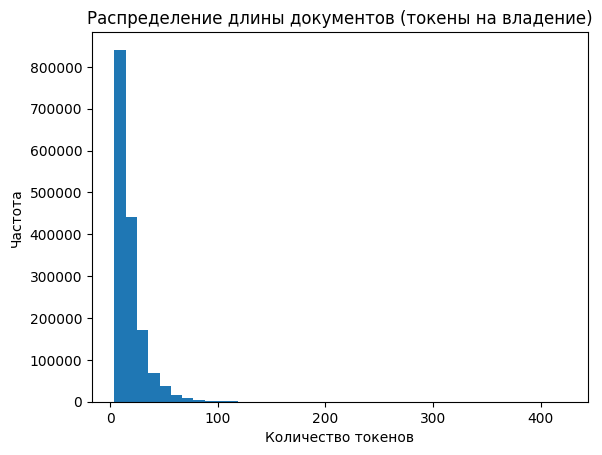


Всего уникальных токенов: 143

Топ-30 токенов:
possession_link                3943625
pressure_related               1373867
len_short                      1338818
counterpress_ctx               1325741
pass                           1234109
progress_forward               1176952
ball_receipt                   1165764
carry                          931216
under_pressure                 890856
ph_ground_pass_pass            784692
pb_right_foot                  733341
pp_regular_play                647386
len_medium                     551636
progress_backward              544052
loc_z4x3_22                    534911
loc_z4x3_20                    530306
loc_z4x3_10                    515344
loc_z4x3_12                    495857
loc_z4x3_11                    455787
progress_lateral               444321
angle_forward                  439520
pressure                       409921
loc_z4x3_21                    384703
pp_from_throw_in               379476
loc_z4x3_01                    35

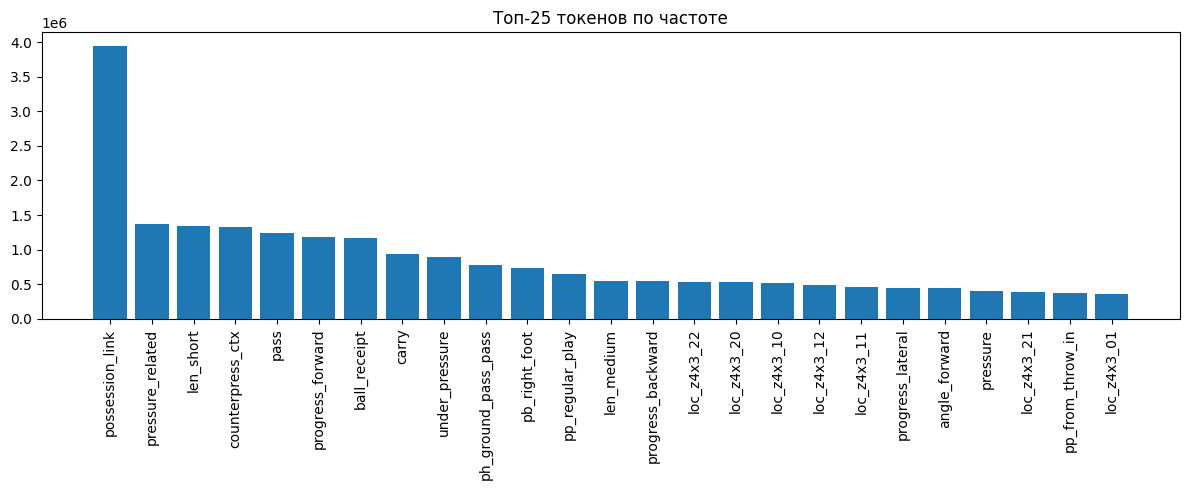

In [27]:
# === Cell 4: Tokenizer EDA ===

# длины документов (владений игрока)
doc_lengths = [len(tokens) for tokens in docs_player_poss.values()]

print(f"Всего документов (player-possession): {len(doc_lengths)}")
print(f"Средняя длина документа: {np.mean(doc_lengths):.2f} токенов")
print(f"Медианная длина документа: {median(doc_lengths):.2f}")
print(f"Минимум / максимум: {min(doc_lengths)} / {max(doc_lengths)}")

plt.hist(doc_lengths, bins=40)
plt.title("Распределение длины документов (токены на владение)")
plt.xlabel("Количество токенов")
plt.ylabel("Частота")
plt.show()

# частоты токенов
all_tokens = []
for tokens in docs_player_poss.values():
    all_tokens.extend(tokens)

token_counts = Counter(all_tokens)
print(f"\nВсего уникальных токенов: {len(token_counts)}")

print("\nТоп-30 токенов:")
for tok_, cnt in token_counts.most_common(30):
    print(f"{tok_:30s} {cnt}")

# barplot топ-токенов
top_n = 25
top_tokens, top_freqs = zip(*token_counts.most_common(top_n))

plt.figure(figsize=(12, 5))
plt.bar(range(top_n), top_freqs)
plt.xticks(range(top_n), top_tokens, rotation=90)
plt.title(f"Топ-{top_n} токенов по частоте")
plt.tight_layout()
plt.show()


### Таблица игроков

Формируем player_info: суммарные минуты, типичные позиции и клубы. Эти метаданные позже присоединяются к эмбеддингам и отчётам.

In [37]:
# Минуты по игрокам
player_minutes = minutes_df.groupby("player_id")["minutes_played"].sum()

def mode_or_first(series: pd.Series):
    m = series.mode()
    if len(m) > 0:
        return m.iloc[0]
    return series.iloc[0]

player_info = (
    events_df
    .dropna(subset=["player_id"])
    .groupby("player_id")
    .agg(
        player_name=("player_name", mode_or_first),
        team_id=("team_id", mode_or_first),
        team_name=("team_name", mode_or_first),
        position_name=("position_name", mode_or_first),
    )
)

player_info["minutes_played"] = player_minutes
player_info["minutes_played"] = player_info["minutes_played"].fillna(0)

print("Пример player_info:")
display(player_info.head(10))

print("\nРаспределение минут по игрокам:")
print(player_info["minutes_played"].describe())


Пример player_info:


,player_name,team_id,team_name,position_name,minutes_played
player_id,,,,,
2941.0,Ismaïla Sarr,787,Senegal,Right Wing,669.613350
2948.0,Nabil Fekir,771,France,Center Attacking Midfield,0.000000
2954.0,Youri Tielemans,782,Belgium,Right Defensive Midfield,661.250883
2956.0,Bertrand Isidore Traoré,33,Chelsea,Center Forward,377.802933
2966.0,Stéphane Sessègnon,27,West Bromwich Albion,Right Midfield,1979.984633
2968.0,Elias Kachunga,189,Ingolstadt,Center Forward,280.487167
2972.0,Marcus Thuram,771,France,Left Wing,0.000000
2974.0,Saîf-Eddine Khaoui,777,Tunisia,Left Center Midfield,0.000000
2988.0,Memphis Depay,39,Manchester United,Left Wing,2208.443183



Распределение минут по игрокам:
count    2680.000000
mean      937.128805
std      1056.672149
min         0.000000
25%        97.514217
50%       411.595550
75%      1580.835929
max      5301.706617
Name: minutes_played, dtype: float64


# Модель Player2Vec на основе TF-IDF

Описание подхода TF-IDF для владений: строим текстовые представления эпизодов и преобразуем их в числовые вектора игроков/сезонов.

In [29]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 1. Подготовка корпуса владений (player-possession) для TF-IDF

print("\n[TF-IDF] Построение корпуса владений для TF-IDF")

# docs_player_poss: dict[(player_id, match_id, possession_id) -> List[str]]
poss_keys = list(docs_player_poss.keys())
poss_texts = [" ".join(tokens) for tokens in docs_player_poss.values()]

print(f"[TF-IDF] Всего документов (player-possession): {len(poss_texts):,}")
if poss_texts:
    print("[TF-IDF] Пример документа (обрезан до 200 символов):")
    print(poss_texts[0][:200], "...")
    print()



[TF-IDF] Построение корпуса владений для TF-IDF
[TF-IDF] Всего документов (player-possession): 1,594,994
[TF-IDF] Пример документа (обрезан до 200 символов):
pp_from_kick_off counterpress_ctx possession_starter pass loc_z4x3_21 len_short angle_backward progress_backward ph_ground_pass_pass ptype_kick_off pb_right_foot possession_link ball_recovery loc_z4x3 ...



In [30]:

# Оставляем только владения с полными тройными ключами (player_id, match_id, possession_id)
filtered_docs = [
    (k, v)
    for k, v in docs_player_poss.items()
    if isinstance(k, (tuple, list)) and len(k) == 3
]
removed = len(docs_player_poss) - len(filtered_docs)
if removed:
    print(f"[TF-IDF] Отброшены документы с нетройными ключами: {removed}")

poss_keys = [k for k, _ in filtered_docs]
poss_texts = [" ".join(v) for _, v in filtered_docs]
print(f"[TF-IDF] Оставшиеся документы-владения: {len(poss_keys):,} possessions")



[TF-IDF] Отброшены документы с нетройными ключами: 1
[TF-IDF] Оставшиеся документы-владения: 1,594,993 possessions


### Обучаем TF-IDF на владениях

Готовим корпус владений, обучаем TfidfVectorizer (ограничение по min_df/max_df), получаем разреженную матрицу и проверяем её размер.

In [31]:

tfidf_vectorizer = TfidfVectorizer(
    min_df=5,    # игнорируем очень редкие токены
    max_df=0.9,  # игнорируем слишком частые токены
)

X_tfidf_possessions = tfidf_vectorizer.fit_transform(poss_texts)

print("[TF-IDF] Матрица владений:")
print(f"  размер = {X_tfidf_possessions.shape} (n_possessions × n_tokens)")
density = X_tfidf_possessions.nnz / (X_tfidf_possessions.shape[0] * X_tfidf_possessions.shape[1])
print(f"  плотность = {density:.6f}")
print()


[TF-IDF] Матрица владений:
  размер = (1594993, 142) (n_possessions × n_tokens)
  плотность = 0.085002



Строим по владениям TF-IDF векторы для дальнейшего сезонного расчёта

In [32]:

possession_tfidf_vectors = {}

if "X_tfidf_possessions" in globals() and "poss_keys" in globals():
    for i, key in enumerate(poss_keys):
        try:
            possession_tfidf_vectors[key] = X_tfidf_possessions.getrow(i).toarray().ravel()
        except Exception:
            continue

print(f"[TF-IDF] Вектора владения построены: {len(possession_tfidf_vectors)}")



[TF-IDF] Вектора владения построены: 1594993


### Агрегация TF-IDF владений в вектора игроков (усреднение по владениям)

Усредняем TF-IDF вектора по игроку или игроку-сезону, получая стабильное представление стиля игры на длинной дистанции.

In [38]:

from collections import defaultdict

player_to_rows = defaultdict(list)

for row_idx, key in enumerate(poss_keys):
    player_id, match_id, poss_id = key
    player_to_rows[player_id].append(row_idx)

print(f"[TF-IDF] Игроков, у которых есть владения: {len(player_to_rows):,}")

rows = []
for player_id, row_ids in player_to_rows.items():
    # усредняем sparse-вектора владений игрока
    vec_sparse = X_tfidf_possessions[row_ids].mean(axis=0)
    vec = np.asarray(vec_sparse).ravel()
    rows.append(
        {
            "player_id": player_id,
            "n_possessions_tfidf": len(row_ids),
            "vector_tfidf": vec,
        }
    )

player_tfidf_df = pd.DataFrame(rows).set_index("player_id")

# подмерджим метаданные игроков (player_info уже построен выше и имеет index=player_id)
player_tfidf_df = player_tfidf_df.join(player_info, how="left")

print("[TF-IDF] Пример player_tfidf_df:")
display(player_tfidf_df.head(10))



[TF-IDF] Игроков, у которых есть владения: 2,680
[TF-IDF] Пример player_tfidf_df:


,n_possessions_tfidf,vector_tfidf,player_name,team_id,team_name,position_name,minutes_played
player_id,,,,,,,
6994.0,2636,"[0.0020830186669667447, 0.016384542919117305, ...",Marten de Roon,228,Atalanta,Center Defensive Midfield,3713.888200
8420.0,1474,"[0.0009285192524996936, 0.025274522021402377, ...",Luca Cigarini,228,Atalanta,Left Center Midfield,1789.294017
6992.0,1476,"[0.0005958478680314005, 0.016831272873280706, ...",Andrea Masiello,228,Atalanta,Right Back,2259.974600
6941.0,1699,"[0.0021223006892491106, 0.029410053228883733, ...",Jasmin Kurtič,228,Atalanta,Left Center Midfield,2637.542850
7796.0,1658,"[0.0030448974988326197, 0.028053140549301706, ...",Silvan Widmer,230,Udinese,Right Wing Back,2519.504333
5512.0,1513,"[0.001757231996532414, 0.022010442319926354, 0...",Emil Hallfreðsson,226,Hellas Verona,Left Center Midfield,2162.152900
8184.0,751,"[0.0029504568434510405, 0.025236834353776185, ...",Marco D''Alessandro,228,Atalanta,Right Wing,1031.541600
8272.0,2196,"[0.001080520761206805, 0.032300528585274525, 0...",Cyril Théréau,230,Udinese,Left Center Forward,3003.662550
19847.0,862,"[0.0017690026543530513, 0.0219754933084413, 0....",Alessandro Diamanti,228,Atalanta,Center Attacking Midfield,844.007783


### Функция поиска похожих игроков по TF-IDF

Функция ближайших соседей по косинусной мере с фильтрами по минутам, командам и позициям — основа для скаутингового поиска.

In [ ]:

def find_similar_players_tfidf(
    target_player_id: int,
    tfidf_df: pd.DataFrame,
    topn: int = 10,
    min_minutes: float = 300.0,
    same_team: bool | None = None,
    restrict_position: bool = False,
) -> pd.DataFrame:
    """
    Поиск игроков, похожих по TF-IDF-вектору стиля владений.

    Параметры аналогичны find_similar_players_by_id (Word2Vec):
      - min_minutes: минимальное количество минут у кандидатов
      - same_team:
          True  -> только игроки той же команды
          False -> только игроки других команд
          None  -> не фильтровать по команде
      - restrict_position:
          True  -> только с той же позицией (position_name)
    """
    if target_player_id not in tfidf_df.index:
        raise ValueError(f"У игрока {target_player_id} нет TF-IDF-вектора.")

    target_row = tfidf_df.loc[target_player_id]
    v0 = np.asarray(target_row["vector_tfidf"])
    team0 = target_row.get("team_id")
    pos0 = target_row.get("position_name")

    rows = []
    for pid, row in tfidf_df.iterrows():
        if pid == target_player_id:
            continue

        minutes = float(row.get("minutes_played", 0.0) or 0.0)
        if minutes < min_minutes:
            continue

        if same_team is True and row.get("team_id") != team0:
            continue
        if same_team is False and row.get("team_id") == team0:
            continue

        if restrict_position and pos0 is not None:
            if row.get("position_name") != pos0:
                continue

        v = np.asarray(row["vector_tfidf"])
        sim = cosine_sim(v0, v)  # ! 
        rows.append(
            {
                "player_id": pid,
                "player_name": row.get("player_name"),
                "team_name": row.get("team_name"),
                "position": row.get("position_name"),
                "minutes_played": minutes,
                "similarity_tfidf": sim,
            }
        )

    res_df = pd.DataFrame(rows)
    if res_df.empty:
        return res_df

    res_df = res_df.sort_values("similarity_tfidf", ascending=False).head(topn)
    return res_df.reset_index(drop=True)



### Пример использования TF-IDF-сцаутинга

Практический пример: выбираем игрока по подстроке, ищем топ-10 наиболее похожих и выводим имена/клубы/позиции.

In [35]:

def cosine_sim(a: np.ndarray, b: np.ndarray) -> float:
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        return 0.0
    return float(np.dot(a, b) / (na * nb))


def find_similar_players_by_id(
    target_player_id: int,
    player_emb_df: pd.DataFrame,
    topn: int = 10,
    min_minutes: float = 300.0,
    same_team: bool | None = None,
    restrict_position: bool = False,
) -> pd.DataFrame:
    """
    same_team:
        True  -> только игроки той же команды
        False -> только игроки других команд
        None  -> игнорировать команду
    restrict_position:
        True  -> оставлять только игроков с такой же position_name
    """
    if target_player_id not in player_emb_df.index:
        raise ValueError(f"У игрока {target_player_id} нет вектора (мало владений / токенов).")
    
    target_row = player_emb_df.loc[target_player_id]
    v0 = np.asarray(target_row["vector"])
    team0 = target_row["team_id"]
    pos0 = target_row["position_name"]
    
    rows = []
    for pid, row in player_emb_df.iterrows():
        if pid == target_player_id:
            continue
        
        minutes = row.get("minutes_played", 0.0)
        if minutes < min_minutes:
            continue
        
        if same_team is True and row.get("team_id") != team0:
            continue
        if same_team is False and row.get("team_id") == team0:
            continue
        
        if restrict_position and row.get("position_name") != pos0:
            continue
        
        v = np.asarray(row["vector"])
        sim = cosine_sim(v0, v)
        
        rows.append({
            "player_id": pid,
            "player_name": row.get("player_name"),
            "team_name": row.get("team_name"),
            "position": row.get("position_name"),
            "minutes_played": minutes,
            "similarity": sim,
        })
    
    res_df = pd.DataFrame(rows)
    if res_df.empty:
        return res_df
    
    res_df = res_df.sort_values("similarity", ascending=False).head(topn)
    return res_df.reset_index(drop=True)


def find_player_ids_by_name(name_substr: str, player_info: pd.DataFrame) -> pd.DataFrame:
    mask = player_info["player_name"].str.contains(name_substr, case=False, na=False)
    return player_info.loc[mask][["player_name", "team_name", "minutes_played", "position_name"]]


In [39]:

if not player_tfidf_df.empty:
    print("\n[TF-IDF] Пример: поиск похожих игроков по TF-IDF")

    target_name_substr = "Messi"  # !
    candidates = find_player_ids_by_name(target_name_substr, player_info)

    print("Кандидаты по имени:")
    display(candidates)

    if not candidates.empty:
        target_player_id = int(candidates.index[0])
        print(
            f"\nБерём игрока {player_info.loc[target_player_id, 'player_name']} "
            f"(id={target_player_id}) для TF-IDF-скаутинга"
        )

        similar_tfidf = find_similar_players_tfidf(
            target_player_id,
            player_tfidf_df,
            topn=10,
            min_minutes=300.0,
            same_team=False,
            restrict_position=True,
        )

        print("\nТоп-10 похожих игроков по TF-IDF:")
        display(similar_tfidf)
        display(similar_tfidf["player_name"].to_list())
    else:
        print("Игрок с такой подстрокой в имени не найден (для TF-IDF-примера).")
else:
    print("[TF-IDF] player_tfidf_df пуст – возможно, слишком жёсткие фильтры min_df/max_df.")



[TF-IDF] Пример: поиск похожих игроков по TF-IDF
Кандидаты по имени:


,player_name,team_name,minutes_played,position_name
player_id,,,,
5503.0,Lionel Andrés Messi Cuccittini,Argentina,1185.21885,Right Center Forward



Берём игрока Lionel Andrés Messi Cuccittini (id=5503) для TF-IDF-скаутинга

Топ-10 похожих игроков по TF-IDF:


,player_id,player_name,team_name,position,minutes_played,similarity_tfidf
0,5743.0,Paulo Bruno Exequiel Dybala,Juventus,Right Center Forward,2619.238250,0.976725
1,3708.0,Kelechi Promise Iheanacho,Manchester City,Right Center Forward,850.315150,0.955149
2,8806.0,Lars Edi Stindl,Borussia Mönchengladbach,Right Center Forward,2588.217733,0.938536
3,40124.0,Rickie Lambert,West Bromwich Albion,Right Center Forward,471.387533,0.926780
4,20750.0,Cody Mathès Gakpo,Netherlands,Right Center Forward,516.275133,0.924575
5,22041.0,Marko Livaja,Empoli,Right Center Forward,666.419050,0.922058
6,7165.0,Rodrigo Sebastián Palacio,Inter Milan,Right Center Forward,1220.243400,0.920969
7,8557.0,Martin Harnik,VfB Stuttgart,Right Center Forward,924.440850,0.919817
8,7054.0,Manuel Pucciarelli,Empoli,Right Center Forward,3105.136817,0.913527
9,8259.0,Steven Bergwijn,Netherlands,Right Center Forward,324.041067,0.911473


['Paulo Bruno Exequiel Dybala',
 'Kelechi Promise Iheanacho',
 'Lars Edi Stindl',
 'Rickie Lambert',
 'Cody Mathès Gakpo',
 'Marko Livaja',
 'Rodrigo Sebastián Palacio',
 'Martin Harnik',
 'Manuel Pucciarelli',
 'Steven Bergwijn']

# Player2Vec на основе Word2Vec

Обучаем Word2Vec на последовательностях токенов владений для более контекстных эмбеддингов.

In [40]:
# Список предложений (документов) для Word2Vec
sentences = list(docs_player_poss.values())

print(f"Всего предложений (владений игрока): {len(sentences)}")


Всего предложений (владений игрока): 1594994


In [41]:

w2v_params = dict(
    vector_size=128,   # размер скрытого пространства
    window=8,          # окно контекста
    min_count=5,       # минимальная частота токена, чтобы его учитывать
    workers=11,         # число потоков
    sg=1,              # 1 = skip-gram, 0 = CBOW
    hs=0,
    negative=10,
    seed=RANDOM_STATE,
)

print("Параметры Word2Vec:", w2v_params)

w2v_model_path = cache_dir / "word2vec_player_possessions.model"

if w2v_model_path.exists():
    w2v_model = Word2Vec.load(str(w2v_model_path))
    print(f"Загружена сохранённая модель Word2Vec из {w2v_model_path}")
else:
    w2v_model = Word2Vec(
        sentences=sentences,
        **w2v_params
    )
    w2v_model.save(str(w2v_model_path))
    print(f"Обучение Word2Vec завершено. Модель сохранена в {w2v_model_path}")

print("Размер словаря:", len(w2v_model.wv))
print("Пример ближайших к токену 'pass':")
if "pass" in w2v_model.wv:
    print(w2v_model.wv.most_similar("pass", topn=10))
else:
    print("Токен 'pass' не попал в словарь (min_count слишком большой?).")


Параметры Word2Vec: {'vector_size': 128, 'window': 8, 'min_count': 5, 'workers': 11, 'sg': 1, 'hs': 0, 'negative': 10, 'seed': 42}
Загружена сохранённая модель Word2Vec из cache\word2vec_player_possessions.model
Размер словаря: 142
Пример ближайших к токену 'pass':
[('pt_nan', 0.5661303400993347), ('len_medium', 0.5077258944511414), ('pb_right_foot', 0.4757155776023865), ('progress_forward', 0.4568864107131958), ('len_long', 0.45612746477127075), ('angle_right', 0.4464281499385834), ('angle_left', 0.44602370262145996), ('pb_left_foot', 0.4247264564037323), ('len_short', 0.4216002821922302), ('ph_ground_pass_pass', 0.4075907766819)]


## Эмбеддинги

Строим средние вектора владений и игроков на базе Word2Vec, проверяем словарь и смотрим примеры ближайших токенов для проверки.

In [42]:

def sentence_vector(tokens: List[str], model: Word2Vec) -> np.ndarray | None:
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    if not vecs:
        return None
    return np.mean(vecs, axis=0)

# векторы владений
possession_vectors: Dict[Tuple[int, int, int], np.ndarray] = {}

for key, tokens in docs_player_poss.items():
    v = sentence_vector(tokens, w2v_model)
    if v is not None:
        possession_vectors[key] = v

print(f"Векторов владений построено: {len(possession_vectors)}")

# ! агрегируем по игроку -> средний вектор всех его владений
player_vecs_accum: Dict[int, List[np.ndarray]] = defaultdict(list)

for (player_id, match_id, poss_id), vec in possession_vectors.items():
    player_vecs_accum[player_id].append(vec)

player_embeddings: Dict[int, np.ndarray] = {}
for pid, vec_list in player_vecs_accum.items():
    player_embeddings[pid] = np.mean(vec_list, axis=0)

print(f"Игроков с вектором стиля: {len(player_embeddings)} из {player_info.shape[0]}")

# DataFrame с эмбеддингами
player_emb_df = (
    pd.DataFrame({
        "player_id": list(player_embeddings.keys()),
        "vector": list(player_embeddings.values()),
    })
    .set_index("player_id")
)

# добавим информацию об игроках
player_emb_df = player_emb_df.join(player_info, how="left")

print("Пример player_emb_df:")
display(player_emb_df.head(10))


Векторов владений построено: 1594993
Игроков с вектором стиля: 2680 из 2680
Пример player_emb_df:


,vector,player_name,team_id,team_name,position_name,minutes_played
player_id,,,,,,
6994.0,"[-0.21141107, 0.082894534, -0.061685774, -0.06...",Marten de Roon,228,Atalanta,Center Defensive Midfield,3713.888200
8420.0,"[-0.20479625, 0.07334336, -0.05546409, -0.0592...",Luca Cigarini,228,Atalanta,Left Center Midfield,1789.294017
6992.0,"[-0.2536066, 0.04928758, -0.05086839, -0.03189...",Andrea Masiello,228,Atalanta,Right Back,2259.974600
6941.0,"[-0.18873812, 0.07808497, -0.063680604, -0.086...",Jasmin Kurtič,228,Atalanta,Left Center Midfield,2637.542850
7796.0,"[-0.24634404, 0.04834685, -0.056428023, -0.063...",Silvan Widmer,230,Udinese,Right Wing Back,2519.504333
5512.0,"[-0.18179043, 0.08480363, -0.05564179, -0.0748...",Emil Hallfreðsson,226,Hellas Verona,Left Center Midfield,2162.152900
8184.0,"[-0.20553897, 0.06578418, -0.066416696, -0.103...",Marco D''Alessandro,228,Atalanta,Right Wing,1031.541600
8272.0,"[-0.16936703, 0.07630874, -0.07118961, -0.1075...",Cyril Théréau,230,Udinese,Left Center Forward,3003.662550
19847.0,"[-0.19091232, 0.064895116, -0.048842717, -0.07...",Alessandro Diamanti,228,Atalanta,Center Attacking Midfield,844.007783


## Скаутинг

Используем полученные Word2Vec-вектора для поиска похожих игроков, генерации рекомендаций и визуализации кластеров.

In [ ]:

# находим интересующего игрока по имени (подстрока)
target_name_substr = "Messi"   # <-- поменяй на интересующее имя
# target_name_substr = "Barrios" # ФК Зенит
# target_name_substr = "Luiz Henrique", "Gerson" "Douglas Santos""Kerzhakov""Mostovoy" не находит  "Erokhin" нет игрового времени
candidates = find_player_ids_by_name(target_name_substr, player_info)

print("Кандидаты по имени:")
display(candidates)

# ! если есть несколько однофамильцев, берётся первый
if not candidates.empty:
    target_player_id = candidates.index[0]
    print(f"\nБерём игрока {player_info.loc[target_player_id, 'player_name']} (id={target_player_id})")

    similar_df = find_similar_players_by_id(
        target_player_id,
        player_emb_df,
        topn=10,
        min_minutes=300,
        same_team=False,        # только игроки из других команд
        restrict_position=True  # только та же позиция
    )

    print("\nТоп-10 похожих игроков (кандидаты на замену):")
    display(similar_df)
    print(similar_df["player_name"])
else:
    print("Игрок с такой подстрокой в имени не найден.")


Кандидаты по имени:


,player_name,team_name,minutes_played,position_name
player_id,,,,
5503.0,Lionel Andrés Messi Cuccittini,Argentina,1185.21885,Right Center Forward



Берём игрока Lionel Andrés Messi Cuccittini (id=5503.0)

Топ-10 похожих игроков (кандидаты на замену):


,player_id,player_name,team_name,position,minutes_played,similarity
0,5743.0,Paulo Bruno Exequiel Dybala,Juventus,Right Center Forward,2619.238250,0.996547
1,8259.0,Steven Bergwijn,Netherlands,Right Center Forward,324.041067,0.991423
2,8806.0,Lars Edi Stindl,Borussia Mönchengladbach,Right Center Forward,2588.217733,0.991186
3,20750.0,Cody Mathès Gakpo,Netherlands,Right Center Forward,516.275133,0.990953
4,40124.0,Rickie Lambert,West Bromwich Albion,Right Center Forward,471.387533,0.990744
5,3708.0,Kelechi Promise Iheanacho,Manchester City,Right Center Forward,850.315150,0.987584
6,7165.0,Rodrigo Sebastián Palacio,Inter Milan,Right Center Forward,1220.243400,0.985675
7,8322.0,André Hahn,Borussia Mönchengladbach,Right Center Forward,551.191933,0.984102
8,4319.0,Edinson Roberto Cavani Gómez,Uruguay,Right Center Forward,384.932467,0.983816
9,5661.0,M''Baye Babacar Niang,AC Milan,Right Center Forward,1502.416400,0.983679


0     Paulo Bruno Exequiel Dybala
1                 Steven Bergwijn
2                 Lars Edi Stindl
3               Cody Mathès Gakpo
4                  Rickie Lambert
5       Kelechi Promise Iheanacho
6       Rodrigo Sebastián Palacio
7                      André Hahn
8    Edinson Roberto Cavani Gómez
9           M''Baye Babacar Niang
Name: player_name, dtype: object


# Player2Vec на основе Doc2Vec

Doc2Vec даёт вектор на документ (владение), который затем агрегируется до уровня игрока или сезона.

In [44]:

def make_doc_tag(key, idx: int) -> str:
    if isinstance(key, tuple) and len(key) == 3:
        return f"{key[0]}_{key[1]}_{key[2]}"
    try:
        return "_".join(map(str, key))
    except Exception:
        return f"doc_{idx}_{key}"

doc_tags = {}
tagged_docs = []
for idx, (key, tokens) in enumerate(docs_player_poss.items()):
    tag = make_doc_tag(key, idx)
    doc_tags[key] = tag
    tagged_docs.append(TaggedDocument(words=tokens, tags=[tag]))

print(f"Документов использовано для Doc2Vec: {len(tagged_docs)}")

d2v_params = dict(
    vector_size=128,
    window=8,
    min_count=5,
    workers=11,
    dm=1,              # 1 = distributed memory, 0 = DBOW
    hs=0,
    negative=10,
    seed=RANDOM_STATE,
)

d2v_model_path = cache_dir / "doc2vec_player_possessions.model"

doc2vec_model = None
if d2v_model_path.exists():
    doc2vec_model = Doc2Vec.load(str(d2v_model_path))
    print(f"Загружена сохранённая Doc2Vec модель из {d2v_model_path}")
elif tagged_docs:
    doc2vec_model = Doc2Vec(tagged_docs, **d2v_params)
    doc2vec_model.save(str(d2v_model_path))
    print(f"Doc2Vec обучена и сохранена в {d2v_model_path}")
else:
    print("docs_player_poss пуст — Doc2Vec обучение пропущено.")

d2v_model = doc2vec_model  # alias для следующих ячеек

if doc2vec_model is not None:
    doc2vec_model

    print("Doc2Vec vocabulary size:", len(doc2vec_model.wv))

    if doc_tags:
        example_key, example_tag = next(iter(doc_tags.items()))
        print("Пример тега владения:", example_tag)

        similar_docs = doc2vec_model.dv.most_similar(example_tag, topn=5)
        print()
        print("Похожие владения:")
        for tag, sim in similar_docs:
            print(tag, sim)
    else:
        print("Нет тегов владений для примера.")
else:
    print("Doc2Vec модель не создана/не загружена.")


Документов использовано для Doc2Vec: 1594994
Загружена сохранённая Doc2Vec модель из cache\doc2vec_player_possessions.model
Doc2Vec vocabulary size: 142
Пример тега владения: 6994.0_3879863_2

Похожие владения:
7846.0_3890267_33 0.8349365592002869
5469.0_3879817_7 0.8211408257484436
7035.0_3879862_80 0.8197725415229797
6984.0_3879817_61 0.8171407580375671
12304.0_3890263_77 0.8166497945785522


### Эмбеддинги игроков и задача скаутинга

Собираем Doc2Vec-вектора владений, усредняем по игрокам и применяем те же функции поиска аналогов.

In [40]:

from collections import defaultdict
import numpy as np
import pandas as pd

# Подтягиваем источник документов и соответствие ключей тегам
if 'docs_poss' in globals():
    doc_source = docs_poss
else:
    doc_source = docs_player_poss

tag_mapping = doc_tags if 'doc_tags' in globals() else {}

def make_doc_tag(key, idx: int) -> str:
    if isinstance(key, tuple) and len(key) == 3:
        return f"{key[0]}_{key[1]}_{key[2]}"
    try:
        return "_".join(map(str, key))
    except Exception:
        return f"doc_{idx}_{key}"

def extract_player_id(key):
    if isinstance(key, (tuple, list)) and len(key) > 0:
        return key[0]
    try:
        return int(str(key).split("_")[0])
    except Exception:
        return None

player_doc2vec_vectors = defaultdict(list)

if 'd2v_model' in globals() and d2v_model is not None:
    for idx, key in enumerate(doc_source.keys()):
        player_id = extract_player_id(key)
        if player_id is None:
            continue

        tag = tag_mapping.get(key) if tag_mapping else None
        if tag is None:
            tag = make_doc_tag(key, idx)

        try:
            vec = d2v_model.dv[tag]  # тот же tag, что использовался при обучении Doc2Vec
        except KeyError:
            continue

        player_doc2vec_vectors[player_id].append(vec)
else:
    print("Doc2Vec модель не готова — пропускаем построение эмбеддингов.")

rows = []
for pid, vecs in player_doc2vec_vectors.items():
    if not vecs:
        continue
    vecs_arr = np.vstack(vecs)
    rows.append(
        {
            "player_id": pid,
            "n_possessions_doc2vec": len(vecs),
            "vector_doc2vec": vecs_arr.mean(axis=0),
        }
    )

player_doc2vec_df = pd.DataFrame(rows)

# Если в пайплайне уже есть DataFrame с метаданными игроков (например, player_emb_df из Word2Vec),
# подтянем имена и команды, чтобы результат скаутинга был удобнее читать.
if "player_emb_df" in globals() and not player_doc2vec_df.empty:
    player_meta = player_emb_df
    if "player_id" not in player_meta.columns:
        if player_meta.index.name == "player_id":
            player_meta = player_meta.reset_index()
        else:
            player_meta = player_meta.reset_index().rename(columns={"index": "player_id"})
    if "player_id" in player_meta.columns:
        meta_cols = [c for c in ["player_name", "team_name"] if c in player_meta.columns]
        cols_for_merge = ["player_id"] + meta_cols
        player_doc2vec_df = player_doc2vec_df.merge(
            player_meta[cols_for_merge].drop_duplicates("player_id"),
            on="player_id",
            how="left",
        )
    else:
        print("player_emb_df не содержит столбца player_id — метаданные не подмержены.")

print("Всего игроков с Doc2Vec-эмбеддингами:", len(player_doc2vec_df))
player_doc2vec_df.head()


Всего игроков с Doc2Vec-эмбеддингами: 2681


,player_id,n_possessions_doc2vec,vector_doc2vec,player_name,team_name
0,6994.0,2636,"[0.10512158, 0.014573747, -0.0076334234, -0.01...",Marten de Roon,Atalanta
1,8420.0,1474,"[0.10404678, 0.015584724, -0.0078821955, -0.01...",Luca Cigarini,Atalanta
2,6992.0,1476,"[0.1010772, 0.016314162, -0.0008940601, -0.015...",Andrea Masiello,Atalanta
3,6941.0,1699,"[0.10832347, 0.014811517, -0.0035631417, -0.02...",Jasmin Kurtič,Atalanta
4,7796.0,1658,"[0.10674355, 0.016174797, -0.0038311682, -0.00...",Silvan Widmer,Udinese


In [41]:
# %%
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_players_doc2vec(
    player_id: int,
    emb_df: pd.DataFrame,
    topn: int = 10,
    min_possessions: int = 20,
) -> pd.DataFrame:
    """
    Поиск игроков, близких по Doc2Vec-стилю владений к заданному игроку.
    """
    if player_id not in emb_df["player_id"].values:
        raise ValueError(f"player_id={player_id} нет в player_doc2vec_df")

    base_row = emb_df.loc[emb_df["player_id"] == player_id].iloc[0]
    base_vec = base_row["vector_doc2vec"].reshape(1, -1)

    candidates = emb_df.copy()
    candidates = candidates[candidates["player_id"] != player_id]

    if min_possessions is not None:
        candidates = candidates[
            candidates["n_possessions_doc2vec"] >= min_possessions
        ]

    if candidates.empty:
        return candidates

    mat = np.vstack(candidates["vector_doc2vec"].values)
    sims = cosine_similarity(base_vec, mat)[0]

    candidates = candidates.copy()
    candidates["similarity_doc2vec"] = sims

    return candidates.sort_values(
        "similarity_doc2vec", ascending=False
    ).head(topn)


### Пример использования для задачи скаутинга

Выбираем игрока и ищем ближайших по Doc2Vec, чтобы сравнить с результатами Word2Vec/TF-IDF.

In [42]:

if not player_doc2vec_df.empty:
    # для примера возьмём игрока с наибольшим числом владений по Doc2Vec
    target_player_id = int(
        player_doc2vec_df.sort_values(
            "n_possessions_doc2vec", ascending=False
        ).iloc[0]["player_id"]
    )

    similar_players_doc2vec = find_similar_players_doc2vec(
        player_id=target_player_id,
        emb_df=player_doc2vec_df,
        topn=10,
        min_possessions=20,
    )

    print("Ближайшие игроки по Doc2Vec для player_id =", target_player_id)

    # выводим те столбцы, которые реально есть (имена/команды подтянутся, если были в player_emb_df)
    display_cols = [
        c
        for c in [
            "player_id",
            "player_name",
            "team_name",
            "n_possessions_doc2vec",
            "similarity_doc2vec",
        ]
        if c in similar_players_doc2vec.columns
    ]

    print(similar_players_doc2vec[display_cols])
else:
    print("player_doc2vec_df пуст — сначала нужно обучить Doc2Vec и собрать эмбеддинги игроков.")


Ближайшие игроки по Doc2Vec для player_id = 7024
     player_id                       player_name   team_name  \
338     5554.0                   Blerim Džemaili       Genoa   
130    26192.0  Matías Ariel Fernández Fernández  Fiorentina   
187     8284.0                    Amadou Diawara     Bologna   
112    16308.0            Leandro Daniel Paredes      Empoli   
1       8420.0                     Luca Cigarini    Atalanta   
106     5510.0              Lucas Rodrigo Biglia       Lazio   
132     5255.0              Matías Vecino Falero  Fiorentina   
0       6994.0                    Marten de Roon    Atalanta   
212    10919.0                       Juraj Kucka    AC Milan   
410     3167.0                   Antonio Rüdiger     AS Roma   

     n_possessions_doc2vec  similarity_doc2vec  
338                   1469            0.997886  
130                    778            0.997872  
187                   1917            0.997758  
112                   2261            0.997684  
1

### Пример документа игрока

In [47]:
def print_multiple_player_samples(player_documents, num_players=3):
    """
    Выводит краткие примеры документов нескольких игроков для сравнения или анализа.

    Функция полезна для быстрой оценки качества токенизации, разнообразия действий игроков
    и общей структуры сгенерированных данных. Показывает общее количество токенов, небольшую
    выборку первых токенов, а также приблизительное количество игровых событий и позиционных меток.

    Параметры
    ----------
    player_documents : dict
        Словарь, где ключ — идентификатор или имя игрока, а значение — список токенов,
        представляющих его игровую активность (например, владения мячом).
    num_players : int, optional, по умолчанию 3
        Количество игроков, документы которых следует отобразить.

    Печать
    -----
    Выводит:
      - Заголовок
      - Для каждого из `num_players` игроков:
        - Порядковый номер и имя
        - Общее количество токенов
        - Первые 5 токенов (пример)
        - Приблизительное количество игровых событий (по ключевым словам)
        - Количество позиционных токенов (начинающихся с 'pos_')


    """
    print("PLAYER DOCUMENT SAMPLES")
    print("=" * 50)

    if not player_documents:
        print("No player documents available")
        return

    player_names = list(player_documents.keys())[:num_players]

    for i, player_name in enumerate(player_names, 1):
        tokens = player_documents[player_name]

        print(f"\n{i}. {player_name}")
        print(f"   Tokens: {len(tokens)}")
        print(f"   Sample: {', '.join(tokens[:5])}...")

        event_count = sum(
            1 for t in tokens if any(x in t for x in ["pass", "shot", "tackle", "dribble"])
        )
        position_count = sum(1 for t in tokens if t.startswith("pos_"))

        print(f"   Events: {event_count}, Positions: {position_count}")



print("PLAYER DOCUMENT DEMO")
print("=" * 60)

if player_documents:
    print_player_document_example(player_documents)
    print_multiple_player_samples(player_documents, 3)
else:
    print("No player documents loaded")



PLAYER DOCUMENT DEMO
PLAYER DOCUMENT EXAMPLE
Player: Marten de Roon
Total tokens: 44405

First 20 tokens:
------------------------------
 1. pp_from_kick_off
 2. counterpress_ctx
 3. possession_starter
 4. pass
 5. loc_z4x3_21
 6. len_short
 7. angle_backward
 8. progress_backward
 9. ph_ground_pass_pass
10. ptype_kick_off
11. pb_right_foot
12. possession_link
13. ball_recovery
14. loc_z4x3_21
15. possession_link
16. carry
17. loc_z4x3_21
18. len_short
19. progress_forward
20. under_pressure

... and 44385 more tokens
PLAYER DOCUMENT SAMPLES

1. Marten de Roon
   Tokens: 44405
   Sample: pp_from_kick_off, counterpress_ctx, possession_starter, pass, loc_z4x3_21...
   Events: 4221, Positions: 0

2. Luca Cigarini
   Tokens: 27538
   Sample: pp_from_kick_off, counterpress_ctx, possession_link, ball_receipt, loc_z4x3_11...
   Events: 2798, Positions: 0

3. Andrea Masiello
   Tokens: 24387
   Sample: pp_from_kick_off, counterpress_ctx, possession_link, ball_receipt, loc_z4x3_11...
   Events:

# Валидация

Метод проверки: сравниваем соседство сезонов одного игрока с соседством других. Оцениваем, может ли модель находить следующий сезон среди топ-N схожих всех игроков.

## Самоподобие

In [ ]:
MIN_POSSESSIONS_VALIDATION = 50.0
MIN_MINUTES_VALIDATION = 50.0


from collections import defaultdict
from typing import Any, Dict, List, Tuple


def _ensure_start_year(df: pd.DataFrame) -> pd.DataFrame:
    df_out = df.copy()
    if "start_year" not in df_out.columns:
        start_year_series = df_out["season_name"].astype(str).str.extract(r"(\\d{4})")[0]
        df_out["start_year"] = pd.to_numeric(start_year_series, errors="coerce")
    return df_out


def build_player_season_vectors(
    get_vec_fn,
    matches_df: pd.DataFrame,
    vector_col_name: str,
) -> pd.DataFrame:
    """
    Строит векторные представления игроков по сезонам на основе агрегации владений.

    Функция обрабатывает данные о владениях игроков и генерирует DataFrame,
    где каждая строка соответствует комбинации игрок-сезон. Вектор признаков
    вычисляется как среднее по всем векторам владений игрока в этом сезоне.

    Результат включает метаданные: информацию об игроке (если доступна), сезоне,
    количество владений, использованных для агрегации. Данные сортируются по ID игрока и году начала сезона.

    Параметры
    ----------
    get_vec_fn : callable
        Функция, преобразующая владение в вектор. Принимает:
          - key: идентификатор владения (обычно кортеж (player_id, match_id))
          - tokens: список токенов события владения
          - idx: индекс итерации
        Возвращает: вектор (array-like) или None, если вектор построить нельзя.
    matches_df : pd.DataFrame
        Таблица с метаданными матчей. Должна содержать колонки:
          - 'match_id'
          - 'season_id'
          - 'season_name'
        Должна быть обработана функцией `_ensure_start_year`, чтобы включать 'start_year'.
    vector_col_name : str
        Имя столбца, в котором будет сохранён итоговый вектор (среднее по владениям).

    Возвращает
    -------
    pd.DataFrame
        DataFrame с одной строкой на каждую комбинацию игрок-сезон. Содержит:
          - player_id
          - season_id
          - season_name
          - start_year
          - player_name (если доступно в глобальной переменной `player_info`)
          - team_name (если доступно)
          - position_name (если доступно)
          - minutes_played (если доступно)
          - n_possessions_{vector_col_name}: количество владений, участвовавших в усреднении
          - {vector_col_name}: усреднённый вектор признаков по всем владениям в сезоне

        Строки отсортированы по 'player_id' и 'start_year'. Если векторы не были построены — возвращается пустой DataFrame.

    """
    matches_meta = _ensure_start_year(matches_df)
    match_lookup: Dict[int, Dict[str, Any]] = matches_meta.set_index("match_id")[
        ["season_id", "season_name", "start_year"]
    ].to_dict("index")

    acc: Dict[Tuple[int, int], List[np.ndarray]] = defaultdict(list)
    for idx, (key, tokens) in enumerate(docs_player_poss.items()):
        if not isinstance(key, (tuple, list)) or len(key) < 2:
            continue

        match_id = key[1]
        meta = match_lookup.get(match_id)
        if meta is None:
            continue

        vec = get_vec_fn(key, tokens, idx)
        if vec is None:
            continue

        acc[(key[0], meta["season_id"])].append(np.asarray(vec))

    rows = []
    for (pid, season_id), vecs in acc.items():
        arr = np.vstack(vecs)
        rows.append(
            {
                "player_id": pid,
                "season_id": season_id,
                "n_possessions": len(vecs),
                vector_col_name: arr.mean(axis=0),
            }
        )

    df_out = pd.DataFrame(rows)
    if df_out.empty:
        return df_out

    season_meta = (
        matches_meta[["season_id", "season_name", "start_year"]]
        .drop_duplicates("season_id")
    )
    df_out = df_out.merge(season_meta, on="season_id", how="left")

    if "player_info" in globals():
        player_meta = player_info.reset_index()
        if "player_id" not in player_meta.columns:
            player_meta = player_meta.rename(columns={"index": "player_id"})
        keep_cols = [
            c
            for c in [
                "player_id",
                "player_name",
                "team_name",
                "position_name",
                "minutes_played",
            ]
            if c in player_meta.columns
        ]
        df_out = df_out.merge(player_meta[keep_cols], on="player_id", how="left")

    df_out = df_out.sort_values(["player_id", "start_year"]).reset_index(drop=True)
    df_out = df_out.rename(
        columns={"n_possessions": f"n_possessions_{vector_col_name}"}
    )
    return df_out



def evaluate_season_similarity(
    season_df: pd.DataFrame,
    vector_col: str,
    n_possessions_col: str,
    min_possessions: int = 20,
    min_minutes: float | None = 300.0,
    topn: Tuple[int, ...] = (1, 5, 10),
) -> Tuple[Dict[str, float], pd.DataFrame]:
    """
    Оценивает схожесть последовательных сезонов одного и того же игрока по сравнению с сезонами других игроков.

    Функция вычисляет косинусное сходство между векторными представлениями (эмбеддингами) сезонов одного игрока
    и сравнивает его с распределением сходства по другим игрокам. Цель — понять, насколько уникально или предсказуемо
    развитие игрока: похож ли его следующий сезон на предыдущий по сравнению со случайными парами.

    Параметры
    ----------
    season_df : pd.DataFrame
        Таблица с данными о сезонах игроков. Должна включать:
        - 'player_id' — уникальный идентификатор игрока
        - 'season_id' — идентификатор сезона
        - 'start_year' — год начала сезона (для хронологической сортировки)
        - 'player_name' (опционально) — имя игрока
        - 'minutes_played' (опционально) — отыгранные минуты
        - Столбец `vector_col` — векторное представление сезона (эмбеддинг)
        - Столбец `n_possessions_col` — количество владений в сезоне

    vector_col : str
        Имя столбца, содержащего векторные эмбеддинги сезонов.

    n_possessions_col : str
        Имя столбца с количеством владений в сезоне. Используется для фильтрации.

    min_possessions : int, optional, default=20
        Минимальное количество владений для включения сезона в анализ.
        Если None — фильтрация не применяется.

    min_minutes : float or None, optional, default=300.0
        Минимальное количество сыгранных минут для включения сезона.
        Если None — фильтрация по минутам не применяется.

    topn : tuple of int, optional, default=(1, 5, 10)
        Набор рангов, по которым вычисляется "hit rate" — доля случаев,
        когда следующий сезон игрока входит в топ-k похожих сезонов.

    Возвращает
    -------
    summary : dict of {str: float}
        Сводная статистика по анализу:
        - 'pairs_total' — общее число пар последовательных сезонов
        - 'pairs_with_rank' — сколько пар удалось ранжировать
        - 'mean_self_similarity' — среднее косинусное сходство между последовательными сезонами
        - 'gap_vs_mean_others' — средняя разница между self-сходством и средним с другими
        - 'share_self_gt_p95' — доля пар, где self-сходство > 95-го перцентиля с другими
        - 'top{k}_hit_rate' — доля пар, где следующий сезон в топ-k похожих (для каждого k в topn)

    result_df : pd.DataFrame
        Подробные результаты по каждой паре сезонов. Столбцы:
        - 'player_id', 'player_name'
        - 'season_A', 'season_B' — названия сезонов
        - 'start_year_A' — год начала первого сезона
        - 'sim_self' — косинусное сходство между A и B
        - 'sim_others_mean' — среднее сходство A с другими игроками
        - 'sim_others_p95' — 95-й перцентиль сходства A с другими
        - 'rank_next' — место сезона B среди всех похожих на A (1 = самый похожий)

    """
    if season_df.empty:
        print("No data provided for self-similarity evaluation.")
        return {}, pd.DataFrame()

    df = season_df.copy()
    df = df.dropna(subset=[vector_col, "start_year"])
    if min_possessions is not None and n_possessions_col in df.columns:
        df = df[df[n_possessions_col] >= min_possessions]
    if min_minutes is not None and "minutes_played" in df.columns:
        df = df[df["minutes_played"] >= min_minutes]

    if df.empty:
        print("No rows qualify for evaluation (check min_possessions/min_minutes or missing metadata).")
        return {}, pd.DataFrame()

    df = df.reset_index(drop=True)
    vecs = np.vstack(df[vector_col].values)
    norms = np.linalg.norm(vecs, axis=1)
    keep = norms > 0
    if not keep.any():
        print("No non-zero vectors found.")
        return {}, pd.DataFrame()

    df = df.loc[keep].reset_index(drop=True)
    vecs = vecs[keep]
    vecs = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)

    keys = list(zip(df["player_id"], df["season_id"]))
    key_to_idx = {k: i for i, k in enumerate(keys)}

    results = []
    top_hits = {k: 0 for k in topn}
    ranked_pairs = 0

    for pid, group in df.groupby("player_id"):
        group = group.sort_values("start_year")
        for i in range(len(group) - 1):
            row_a = group.iloc[i]
            row_b = group.iloc[i + 1]
            idx_a = key_to_idx.get((pid, row_a["season_id"]))
            idx_b = key_to_idx.get((pid, row_b["season_id"]))
            if idx_a is None or idx_b is None:
                continue

            sims_all = vecs[idx_a] @ vecs.T
            sims_all[idx_a] = -np.inf
            order = np.argsort(sims_all)[::-1]

            rank_next = None
            if idx_b is not None:
                pos = np.where(order == idx_b)[0]
                if len(pos) > 0:
                    rank_next = int(pos[0]) + 1
                    ranked_pairs += 1
                    for k in topn:
                        if rank_next <= k:
                            top_hits[k] += 1

            same_season_idx = np.where(df["season_id"].values == row_a["season_id"])[0]
            same_season_idx = same_season_idx[same_season_idx != idx_a]
            if same_season_idx.size:
                sims_same = vecs[idx_a] @ vecs[same_season_idx].T
                mean_others = float(np.mean(sims_same))
                p95_others = float(np.percentile(sims_same, 95))
            else:
                mean_others = np.nan
                p95_others = np.nan

            sim_self = float(np.dot(vecs[idx_a], vecs[idx_b]))

            results.append(
                {
                    "player_id": pid,
                    "player_name": row_a.get("player_name"),
                    "season_A": row_a.get("season_name"),
                    "season_B": row_b.get("season_name"),
                    "start_year_A": row_a.get("start_year"),
                    "sim_self": sim_self,
                    "sim_others_mean": mean_others,
                    "sim_others_p95": p95_others,
                    "rank_next": rank_next,
                }
            )

    result_df = pd.DataFrame(results)
    summary = {
        "pairs_total": len(result_df),
        "pairs_with_rank": ranked_pairs,
        "mean_self_similarity": result_df["sim_self"].mean() if not result_df.empty else np.nan,
        "gap_vs_mean_others": (result_df["sim_self"] - result_df["sim_others_mean"]).mean()
        if not result_df.empty
        else np.nan,
        "share_self_gt_p95": float(
            (result_df["sim_self"] > result_df["sim_others_p95"]).mean()
        )
        if not result_df.empty
        else np.nan,
    }

    for k in topn:
        summary[f"top{k}_hit_rate"] = (
            top_hits[k] / ranked_pairs if ranked_pairs else np.nan
        )

    return summary, result_df



### TF-IDF

In [ ]:

def build_player_season_tfidf(min_possessions: int = MIN_POSSESSIONS_VALIDATION, topn: tuple[int, ...] = (1, 5, 10), min_minutes: float | None = MIN_MINUTES_VALIDATION):
    """
    Перестраивает векторы владений с использованием TF-IDF и агрегирует их в векторы игроков по сезонам,
    затем оценивает самоподобие последовательных сезонов.

    Эта функция объединяет несколько этапов:
      1. Построение корпуса владений (только с ключами из трёх элементов: player_id, match_id, possession_id)
      2. Обучение векторизатора TF-IDF на токенах владений
      3. Формирование разреженных векторов для каждого владения
      4. Агрегация векторов владений в векторы игроков по сезонам (усреднение)
      5. Оценка качества представления через метрику самоподобия последовательных сезонов

    Параметры
    ----------
    min_possessions : int, optional, default=MIN_POSSESSIONS_VALIDATION
        Минимальное количество владений в сезоне для включения игрока в анализ.
        Фильтрация применяется на этапе оценки.
    topn : tuple of int, optional, default=(1, 5, 10)
        Набор значений рангов, по которым вычисляется hit rate — доля случаев,
        когда следующий сезон игрока находится среди top-k похожих сезонов других игроков.
    min_minutes : float or None, optional, default=MIN_MINUTES_VALIDATION
        Минимальное количество минут, отыгранных в сезоне. Если None — фильтрация не применяется.

    Возвращает
    -------
    player_season_tfidf : pd.DataFrame
        Таблица с векторами игроков по сезонам. Каждая строка — один сезон игрока.
        Содержит:
          - player_id, season_id, season_name, start_year
          - vector_tfidf — усреднённый TF-IDF вектор
          - n_possessions_vector_tfidf — количество владений, использованных для усреднения
          - метаданные игрока (если доступны)
    summary_tfidf : dict of {str: float}
        Сводная статистика по самоподобию:
          - 'pairs_total' — общее число пар последовательных сезонов
          - 'mean_self_similarity' — среднее косинусное сходство между сезонами одного игрока
          - 'top{k}_hit_rate' — доля пар, где следующий сезон входит в топ-k похожих
          - и другие метрики (см. `evaluate_season_similarity`)
    pairs_tfidf : pd.DataFrame
        Детальные результаты оценки по каждой паре сезонов.

    Глобальные переменные (на вход и выход)
    ---------------------------------------
    Функция использует и модифицирует следующие глобальные переменные:
    - docs_player_poss: dict — токенизированные владения (вход)
    - matches_filtered: pd.DataFrame — отфильтрованные матчи (вход)
    - possession_tfidf_vectors: dict — векторы владений (выход)
    - player_season_tfidf: pd.DataFrame — векторы игроков по сезонам (выход)
    - poss_keys, poss_texts: промежуточные данные корпуса (выход)
    - X_tfidf_possessions: разреженная матрица TF-IDF (выход)
    - tfidf_vectorizer: обученный векторизатор (инициализируется при необходимости)

    """
    global possession_tfidf_vectors, player_season_tfidf, poss_keys, poss_texts, X_tfidf_possessions, tfidf_vectorizer

    # Build possession corpus (triplet keys only)
    filtered_docs = [
        (k, v)
        for k, v in docs_player_poss.items()
        if isinstance(k, (tuple, list)) and len(k) == 3
    ]
    if not filtered_docs:
        print("[TF-IDF] No possession docs with triplet keys - cannot build TF-IDF.")
        return pd.DataFrame(), {}, pd.DataFrame()

    poss_keys = [k for k, _ in filtered_docs]
    poss_texts = [' '.join(v) for _, v in filtered_docs]
    print(f"[TF-IDF] Possession corpus size: {len(poss_keys):,}")

    # Fit TF-IDF on possession texts
    if "tfidf_vectorizer" not in globals():
        tfidf_vectorizer = TfidfVectorizer(min_df=5, max_df=0.9)
    X_tfidf_possessions = tfidf_vectorizer.fit_transform(poss_texts)
    print(f"[TF-IDF] Possession matrix shape: {X_tfidf_possessions.shape}")

    # Build possession-level dense vectors
    possession_tfidf_vectors = {}
    for i, key in enumerate(poss_keys):
        possession_tfidf_vectors[key] = X_tfidf_possessions.getrow(i).toarray().ravel()
    print(f"[TF-IDF] Possession vectors built: {len(possession_tfidf_vectors)}")

    if not possession_tfidf_vectors:
        print("TF-IDF possession vectors are missing or empty - run the TF-IDF embedding section first.")
        return pd.DataFrame(), {}, pd.DataFrame()

    # Aggregate to player-season vectors
    tfidf_getter = lambda key, tokens, idx: possession_tfidf_vectors.get(key)
    player_season_tfidf = build_player_season_vectors(
        get_vec_fn=tfidf_getter,
        matches_df=matches_filtered,
        vector_col_name="vector_tfidf",
    )

    print(f"TF-IDF player-season vectors built: {len(player_season_tfidf)}")
    if not player_season_tfidf.empty:
        display(player_season_tfidf.head())

    # Self-similarity evaluation
    summary_tfidf, pairs_tfidf = evaluate_season_similarity(
        season_df=player_season_tfidf,
        vector_col="vector_tfidf",
        n_possessions_col="n_possessions_vector_tfidf",
        min_possessions=min_possessions,
        min_minutes=min_minutes,
        topn=topn,
    )

    if summary_tfidf:
        display(pd.DataFrame([summary_tfidf]))

    if not pairs_tfidf.empty:
        print("Top pairs and self-similarity scores (TF-IDF):")
        display(pairs_tfidf.sort_values("sim_self", ascending=False).head(10))

    return player_season_tfidf, summary_tfidf, pairs_tfidf

# Build TF-IDF season vectors and show self-similarity stats
player_season_tfidf, summary_tfidf, pairs_tfidf = build_player_season_tfidf()



[TF-IDF] Possession corpus size: 1,594,993
[TF-IDF] Possession matrix shape: (1594993, 142)
[TF-IDF] Possession vectors built: 1594993
TF-IDF player-season vectors built: 3577


,player_id,season_id,n_possessions_vector_tfidf,vector_tfidf,season_name,start_year,player_name,team_name,position_name,minutes_played
0,2941.0,3,150,"[0.0, 0.02078563302065709, 0.02396552620193301...",2018,2018,Ismaïla Sarr,Senegal,Right Wing,669.613350
1,2941.0,106,193,"[0.002179052636239853, 0.019205299752657275, 0...",2022,2022,Ismaïla Sarr,Senegal,Right Wing,669.613350
2,2948.0,3,78,"[0.0, 0.017012987938345252, 0.0212991536396911...",2018,2018,Nabil Fekir,France,Center Attacking Midfield,0.000000
3,2954.0,3,131,"[0.0, 0.022589164442014455, 0.0236218295997264...",2018,2018,Youri Tielemans,Belgium,Right Defensive Midfield,661.250883
4,2954.0,43,197,"[0.0, 0.027224044584301752, 0.0357336999540175...",2020,2020,Youri Tielemans,Belgium,Right Defensive Midfield,661.250883


,pairs_total,pairs_with_rank,mean_self_similarity,gap_vs_mean_others,share_self_gt_p95,top1_hit_rate,top5_hit_rate,top10_hit_rate
0,648,648,0.909185,0.152839,0.341049,0.020062,0.063272,0.097222


Top pairs and self-similarity scores (TF-IDF):


,player_id,player_name,season_A,season_B,start_year_A,sim_self,sim_others_mean,sim_others_p95,rank_next
613,16531.0,Dominik Livaković,2020,2022,2020,0.994244,0.433763,0.972580,5
465,5669.0,Wojciech Szczęsny,2020,2022,2020,0.993680,0.440903,0.955948,12
253,5211.0,Jordi Alba Ramos,2020,2022,2020,0.992720,0.711591,0.935596,1
387,5570.0,Manuel Neuer,2020,2022,2020,0.991153,0.525992,0.937526,2
126,3509.0,Thibaut Courtois,2020,2022,2020,0.990776,0.449590,0.957559,5
635,20201.0,Maarten Stekelenburg,2015/2016,2020,2015,0.990202,0.451041,0.983160,61
42,3099.0,Hugo Lloris,2020,2022,2020,0.990111,0.426033,0.966933,6
605,11748.0,Unai Simón Mendibil,2020,2022,2020,0.989559,0.515658,0.934481,2
250,5209.0,Raphaël Adelino José Guerreiro,2020,2022,2020,0.989201,0.709346,0.939256,4
296,5463.0,Luka Modrić,2020,2022,2020,0.988366,0.828529,0.959585,1


#### Модель на основе TF-IDF в среднем находит второй сезон более близким для одного и того же игрока (разница в показателе схожести сезонов gap_vs_mean_others = 0.15), в 10% случаев второй сезон того же игрока оказывается в топ-10 похожих сезонов всех сезоннов всех ироков в массиве.

### Word2Vec

In [47]:

# Word2Vec: self-similarity across player seasons
w2v_getter = lambda key, tokens, idx: possession_vectors.get(key)

player_season_w2v = build_player_season_vectors(
    get_vec_fn=w2v_getter,
    matches_df=matches_filtered,
    vector_col_name="vector_w2v",
)

print(f"Word2Vec player-season vectors built: {len(player_season_w2v)}")
display(player_season_w2v.head())

summary_w2v, pairs_w2v = evaluate_season_similarity(
    season_df=player_season_w2v,
    vector_col="vector_w2v",
    n_possessions_col="n_possessions_vector_w2v",
    min_possessions=MIN_POSSESSIONS_VALIDATION,
    min_minutes=MIN_MINUTES_VALIDATION,
    topn=(1, 5, 10),
)

if summary_w2v:
    display(pd.DataFrame([summary_w2v]))

if not pairs_w2v.empty:
    print("Top pairs and self-similarity scores (Word2Vec):")
    display(pairs_w2v.sort_values("sim_self", ascending=False).head(10))
    
    print("Bottom pairs and self-similarity scores (Word2Vec):")
    display(pairs_w2v.sort_values("sim_self", ascending=False).tail(10))



Word2Vec player-season vectors built: 3577


,player_id,season_id,n_possessions_vector_w2v,vector_w2v,season_name,start_year,player_name,team_name,position_name,minutes_played
0,2941.0,3,150,"[-0.22691931, 0.06355996, -0.06502133, -0.1039...",2018,2018,Ismaïla Sarr,Senegal,Right Wing,669.613350
1,2941.0,106,193,"[-0.16821624, 0.07698485, -0.06853195, -0.0981...",2022,2022,Ismaïla Sarr,Senegal,Right Wing,669.613350
2,2948.0,3,78,"[-0.20180899, 0.06867925, -0.055318262, -0.097...",2018,2018,Nabil Fekir,France,Center Attacking Midfield,0.000000
3,2954.0,3,131,"[-0.22398697, 0.08652953, -0.07125298, -0.0900...",2018,2018,Youri Tielemans,Belgium,Right Defensive Midfield,661.250883
4,2954.0,43,197,"[-0.20821224, 0.076015644, -0.06202502, -0.065...",2020,2020,Youri Tielemans,Belgium,Right Defensive Midfield,661.250883


,pairs_total,pairs_with_rank,mean_self_similarity,gap_vs_mean_others,share_self_gt_p95,top1_hit_rate,top5_hit_rate,top10_hit_rate
0,648,648,0.990075,0.049729,0.487654,0.020062,0.061728,0.091049


Top pairs and self-similarity scores (Word2Vec):


,player_id,player_name,season_A,season_B,start_year_A,sim_self,sim_others_mean,sim_others_p95,rank_next
253,5211.0,Jordi Alba Ramos,2020,2022,2020,0.999382,0.934157,0.990023,1
613,16531.0,Dominik Livaković,2020,2022,2020,0.999315,0.806298,0.997203,9
465,5669.0,Wojciech Szczęsny,2020,2022,2020,0.999154,0.805919,0.995739,30
635,20201.0,Maarten Stekelenburg,2015/2016,2020,2015,0.999146,0.806692,0.998267,44
42,3099.0,Hugo Lloris,2020,2022,2020,0.999141,0.794370,0.995767,1
93,3336.0,Harry Maguire,2020,2022,2020,0.999104,0.950109,0.992102,1
126,3509.0,Thibaut Courtois,2020,2022,2020,0.999082,0.815744,0.995662,7
191,3961.0,N''Golo Kanté,2018,2020,2018,0.998928,0.963501,0.996145,1
99,3436.0,Idrissa Gana Gueye,2015/2016,2018,2015,0.998901,0.963704,0.996957,6
283,5456.0,Mateo Kovačić,2020,2022,2020,0.998781,0.960439,0.994049,1


Bottom pairs and self-similarity scores (Word2Vec):


,player_id,player_name,season_A,season_B,start_year_A,sim_self,sim_others_mean,sim_others_p95,rank_next
493,6300.0,Sebastián Coates Nión,2015/2016,2022,2015,0.952988,0.947961,0.993811,1453
222,5179.0,Daler Kuzyaev,2018,2020,2018,0.952635,0.958175,0.992979,2203
0,2941.0,Ismaïla Sarr,2018,2022,2018,0.950523,0.939116,0.989923,1620
467,5673.0,Bartosz Bereszyński,2020,2022,2020,0.945474,0.952538,0.993615,1858
415,5591.0,Filip Kostić,2018,2022,2018,0.944017,0.931489,0.987917,1536
498,6321.0,Milos Veljkovic,2015/2016,2022,2015,0.943582,0.930981,0.972788,1322
267,5245.0,Achraf Hakimi Mouh,2018,2022,2018,0.942236,0.951159,0.994149,2114
609,16027.0,Kevin Mbabu,2015/2016,2020,2015,0.937434,0.941102,0.984537,1818
98,3404.0,Youssouf Sabaly,2018,2022,2018,0.935855,0.951499,0.994443,2322
338,5524.0,Jens Stryger Larsen,2018,2020,2018,0.928713,0.950230,0.992505,2414


Модель на основе Word2Vec в среднем находит второй сезон более близким для одного и того же игрока (разница в показателе схожести сезонов gap_vs_mean_others = 0.05), в 10% случаев второй сезон того же игрока оказывается в топ-10 похожих сезонов всех сезоннов всех ироков в массиве.

### Doc2Vec

In [48]:

# Doc2Vec: self-similarity across player seasons
if "d2v_model" in globals() and d2v_model is not None:
    doc_tag_map = doc_tags if "doc_tags" in globals() else {}

    def doc_vec_getter(key, tokens, idx):
        tag = doc_tag_map.get(key)
        if tag is None:
            try:
                tag = make_doc_tag(key, idx)
            except Exception:
                tag = None
        if tag is None:
            return None
        try:
            return d2v_model.dv[tag]
        except KeyError:
            return None

    player_season_doc2vec = build_player_season_vectors(
        get_vec_fn=doc_vec_getter,
        matches_df=matches_filtered,
        vector_col_name="vector_doc2vec",
    )

    print(f"Doc2Vec player-season vectors built: {len(player_season_doc2vec)}")
    display(player_season_doc2vec.head())

    summary_doc2vec, pairs_doc2vec = evaluate_season_similarity(
        season_df=player_season_doc2vec,
        vector_col="vector_doc2vec",
        n_possessions_col="n_possessions_vector_doc2vec",
        min_possessions=MIN_POSSESSIONS_VALIDATION,
        min_minutes=MIN_MINUTES_VALIDATION,
        topn=(1, 5, 10),
    )

    if summary_doc2vec:
        display(pd.DataFrame([summary_doc2vec]))

    if not pairs_doc2vec.empty:
        print("Top pairs and self-similarity scores (Doc2Vec):")
        display(pairs_doc2vec.sort_values("sim_self", ascending=False).head(10))
else:
    print("Doc2Vec model is not trained or missing from memory.")



Doc2Vec player-season vectors built: 3577


,player_id,season_id,n_possessions_vector_doc2vec,vector_doc2vec,season_name,start_year,player_name,team_name,position_name,minutes_played
0,2941.0,3,150,"[0.09876917, 0.005048642, -0.01124321, 0.01518...",2018,2018,Ismaïla Sarr,Senegal,Right Wing,669.613350
1,2941.0,106,193,"[0.114282094, 0.009916919, -0.009089569, 0.018...",2022,2022,Ismaïla Sarr,Senegal,Right Wing,669.613350
2,2948.0,3,78,"[0.10986527, -0.0010944357, -0.017268157, 0.01...",2018,2018,Nabil Fekir,France,Center Attacking Midfield,0.000000
3,2954.0,3,131,"[0.11282232, 0.015861988, -0.0063787876, 0.009...",2018,2018,Youri Tielemans,Belgium,Right Defensive Midfield,661.250883
4,2954.0,43,197,"[0.11125933, 0.010963848, -0.008584687, 0.0117...",2020,2020,Youri Tielemans,Belgium,Right Defensive Midfield,661.250883


,pairs_total,pairs_with_rank,mean_self_similarity,gap_vs_mean_others,share_self_gt_p95,top1_hit_rate,top5_hit_rate,top10_hit_rate
0,648,648,0.94352,-0.023967,0.012346,0.001543,0.00463,0.00463


Top pairs and self-similarity scores (Doc2Vec):


,player_id,player_name,season_A,season_B,start_year_A,sim_self,sim_others_mean,sim_others_p95,rank_next
617,18414.0,Bastian Schweinsteiger,2011/2012,2012/2013,2011,0.995093,0.990767,0.994060,2
560,8218.0,Arjen Robben,2011/2012,2012/2013,2011,0.993291,0.987661,0.991581,1
564,8223.0,Franck Bilal Ribéry,2011/2012,2012/2013,2011,0.991548,0.985500,0.990927,4
220,5171.0,Roman Zobnin,2018,2020,2018,0.990552,0.982004,0.994143,101
221,5177.0,Aleksandr Golovin,2018,2020,2018,0.989284,0.977898,0.993431,111
104,3457.0,Michy Batshuayi Tunga,2018,2022,2018,0.988402,0.970249,0.988404,32
160,3629.0,Sadio Mané,2017/2018,2018/2019,2017,0.988063,0.985947,0.991329,27
620,19295.0,Philipp Lahm,2011/2012,2012/2013,2011,0.987535,0.985477,0.991405,25
599,11098.0,Marcus Berg,2018,2020,2018,0.987302,0.984944,0.995821,245
208,4447.0,Martin Braithwaite Christensen,2018,2020,2018,0.987254,0.983656,0.994154,273


Модель Doc2Vec не смогла отличить сезоны одного и того же иргока от других игроков.

## ROC-AUC, kNN-классификация и кластеризация сезонов

Набор метрик для проверки полезности векторов: ROC-AUC и kNN по игрокам, а также кластеризация сезонов по эмбеддингам.

1) Строим датасет пар (сезон A, сезон B) и считаем ROC-AUC по косинусной близости.
2) Оцениваем kNN-классификацию по player_id.
3) Кластеризуем сезоны и смотрим, насколько хорошо кластеры соответствуют игрокам.

In [ ]:

def _prepare_season_df(
    season_df: pd.DataFrame,
    vector_col: str,
    n_possessions_col: str | None = None,
    min_possessions: int | None = None,
    min_minutes: float | None = None,
) -> pd.DataFrame:
    """
    Подготавливает DataFrame с данными по сезонам для задач валидации.

    Выполняет предварительную фильтрацию и очистку данных: удаляет строки с отсутствующими
    векторами или идентификаторами игроков, а также применяет пороговые фильтры по количеству владений
    и отыгранных минут.
    """
    df = season_df.copy()
    df = df.dropna(subset=[vector_col, "player_id"])
    if n_possessions_col and min_possessions is not None and n_possessions_col in df.columns:
        df = df[df[n_possessions_col] >= min_possessions]
    if min_minutes is not None and "minutes_played" in df.columns:
        df = df[df["minutes_played"] >= min_minutes]
    df = df.reset_index(drop=True)
    return df


def _normalize_vectors(X: np.ndarray) -> np.ndarray:
    """
    Normalize vectors row-wise to unit length.
    """
    norms = np.linalg.norm(X, axis=1, keepdims=True)
    norms[norms == 0.0] = 1.0
    return X / norms



In [ ]:

def build_pairwise_similarity_dataset(
    season_df: pd.DataFrame,
    vector_col: str,
    max_pos_pairs_per_player: int = 20,
    neg_pos_ratio: float = 1.0,
    random_state: int = RANDOM_STATE,
    n_possessions_col: str | None = None,
    min_possessions: int | None = None,
    min_minutes: float | None = None,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Создаёт набор данных парных сходств между сезонами игроков для бинарной классификации.

    Генерирует пары векторов сезонов и соответствующие метки:
      - y = 1 — пара из двух сезонов одного игрока (положительная пара)
      - y = 0 — пара из сезонов разных игроков (отрицательная пара)

    Используется для оценки качества векторных представлений: насколько хорошо они сохраняют
    индивидуальные особенности игроков. Чем выше сходство у положительных пар и ниже у отрицательных —
    тем лучше модель.

    Параметры
    ----------
    season_df : pd.DataFrame
        Входная таблица с данными о сезонах игроков. Должна содержать:
        - 'player_id' — идентификатор игрока
        - Столбец `vector_col` — числовой вектор (эмбеддинг) сезона
        - Опционально: 'minutes_played' — отыгранные минуты
    vector_col : str
        Название столбца с векторным представлением сезона (например, 'vector_doc2vec').
    max_pos_pairs_per_player : int, optional, default=20
        Максимальное количество положительных пар (между сезонами одного игрока), которые будут
        отобраны на одного игрока. Ограничение нужно, чтобы избежать перекоса в сторону игроков
        с большим количеством сезонов.
    neg_pos_ratio : float, optional, default=1.0
        Соотношение количества отрицательных пар к положительным. Например, при значении 1.0
        на каждую положительную пару генерируется одна отрицательная. Минимум — 1.
    random_state : int, optional, default=RANDOM_STATE
        Зерно для генератора случайных чисел, обеспечивает воспроизводимость.
    n_possessions_col : str или None, optional
        Название столбца с количеством владений. Если указано, используется в фильтрации.
    min_possessions : int или None, optional
        Минимальное количество владений для включения сезона. Если None — фильтрация не применяется.
    min_minutes : float или None, optional
        Минимальное количество минут для включения сезона. Если None — фильтрация не применяется.

    Возвращает
    -------
    similarities : np.ndarray (float)
        Массив значений косинусного сходства для каждой пары.
    labels : np.ndarray (int)
        Массив бинарных меток: 1 — одна команда, 0 — разные игроки.
        Длина совпадает с `similarities`.

    Логика работы
    --------------
    1. Фильтрация данных по `min_possessions` и `min_minutes`.
    2. Генерация положительных пар: все возможные комбинации сезонов одного игрока (с ограничением).
    3. Для каждой положительной пары:
       - Добавляется сходство между сезонами (метка 1)
       - Генерируется `neg_pos_ratio` отрицательных пар: первый сезон + случайный сезон другого игрока
    4. Каждая отрицательная пара проверяется на принадлежность разным игрокам (до 10 попыток).
    """
    df = _prepare_season_df(
        season_df,
        vector_col,
        n_possessions_col=n_possessions_col,
        min_possessions=min_possessions,
        min_minutes=min_minutes,
    )
    if df.empty:
        return np.array([]), np.array([])

    rng = np.random.default_rng(random_state)

    counts = df["player_id"].value_counts()
    valid_players = counts[counts >= 2].index
    if len(valid_players) == 0:
        return np.array([]), np.array([])

    idx_by_player = {
        pid: df.index[df["player_id"] == pid].tolist()
        for pid in valid_players
    }

    sims: list[float] = []
    labels: list[int] = []

    for pid, indices in idx_by_player.items():
        if len(indices) < 2:
            continue

        all_pairs = [
            (i, j)
            for k, i in enumerate(indices)
            for j in indices[k + 1 :]
        ]
        rng.shuffle(all_pairs)
        all_pairs = all_pairs[:max_pos_pairs_per_player]

        for i, j in all_pairs:
            v1 = df.at[i, vector_col]
            v2 = df.at[j, vector_col]
            sim_pos = cosine_sim(v1, v2)
            sims.append(sim_pos)
            labels.append(1)

            n_neg = max(1, int(neg_pos_ratio))
            for _ in range(n_neg):
                for _trial in range(10):
                    idx_neg = int(rng.integers(0, len(df)))
                    if df.loc[idx_neg, "player_id"] != pid:
                        break
                v_neg = df.at[idx_neg, vector_col]
                sim_neg = cosine_sim(v1, v_neg)
                sims.append(sim_neg)
                labels.append(0)

    if not sims:
        return np.array([]), np.array([])

    return np.array(sims), np.array(labels)




In [ ]:

def evaluate_global_auc(
    season_df: pd.DataFrame,
    vector_col: str,
    model_name: str = "model",
    max_pos_pairs_per_player: int = 20,
    neg_pos_ratio: float = 1.0,
    plot_roc: bool = True,
    n_possessions_col: str | None = None,
    min_possessions: int | None = None,
    min_minutes: float | None = None,
):
    """
    Вычисляет ROC-AUC для пар на данных сезонных векторов.
    """
    sims, labels = build_pairwise_similarity_dataset(
        season_df=season_df,
        vector_col=vector_col,
        max_pos_pairs_per_player=max_pos_pairs_per_player,
        neg_pos_ratio=neg_pos_ratio,
        n_possessions_col=n_possessions_col,
        min_possessions=min_possessions,
        min_minutes=min_minutes,
    )

    if sims.size == 0 or labels.size == 0 or len(np.unique(labels)) < 2:
        print(f"[{model_name}] Not enough data to compute ROC-AUC.")
        return None, None, None

    auc = roc_auc_score(labels, sims)
    fpr, tpr, thresholds = roc_curve(labels, sims)

    print(f"[{model_name}] ROC-AUC = {auc:.4f}, pairs: {len(labels)}")

    if plot_roc:
        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.3f})")
        plt.plot([0, 1], [0, 1], "--", label="chance")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC curve - {model_name}")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    return auc, fpr, tpr


### Построение ROC-AUC кривой для TF-IDF, Word2Vec, Doc2Vec

[TF-IDF (season vectors)] ROC-AUC = 0.8565, pairs: 1944


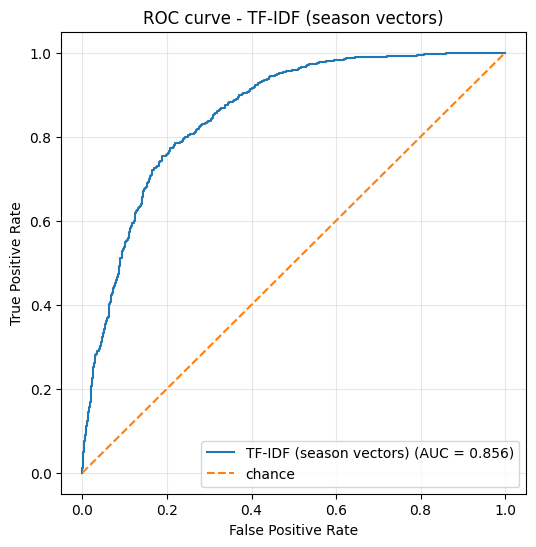

[Word2Vec (season vectors)] ROC-AUC = 0.9009, pairs: 1944


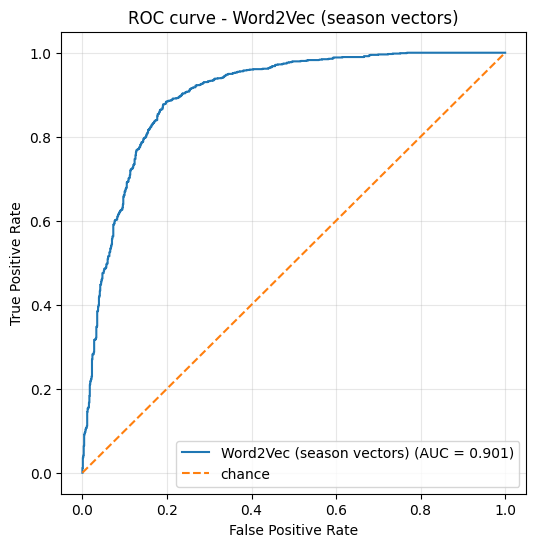

[Doc2Vec (season vectors)] ROC-AUC = 0.5461, pairs: 1944


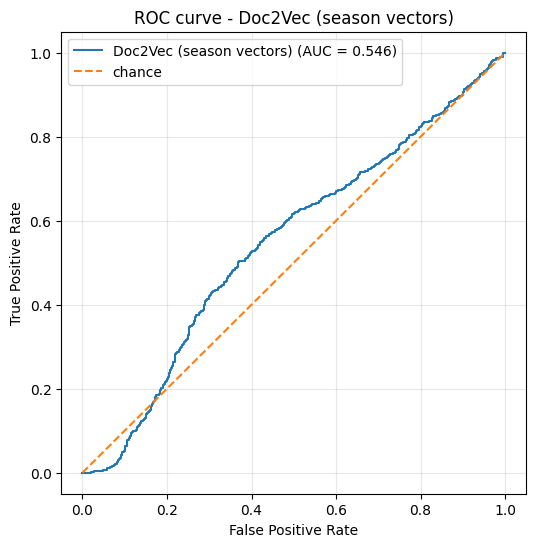

In [52]:

if ('player_season_tfidf' not in globals() or player_season_tfidf.empty) and 'build_player_season_tfidf' in globals():
    player_season_tfidf, summary_tfidf, pairs_tfidf = build_player_season_tfidf()

if 'player_season_tfidf' in globals() and not player_season_tfidf.empty:
    auc_tfidf, fpr_tfidf, tpr_tfidf = evaluate_global_auc(
        season_df=player_season_tfidf,
        vector_col='vector_tfidf',
        model_name='TF-IDF (season vectors)',
        max_pos_pairs_per_player=20,
        neg_pos_ratio=1.0,
        plot_roc=True,
        n_possessions_col='n_possessions_vector_tfidf',
        min_possessions=MIN_POSSESSIONS_VALIDATION,
        min_minutes=MIN_MINUTES_VALIDATION,
    )
else:
    print('player_season_tfidf is undefined or empty - skipping ROC-AUC for TF-IDF.')

# === ROC-AUC for Word2Vec (player-season vectors) ===
if 'player_season_w2v' in globals() and not player_season_w2v.empty:
    auc_w2v, fpr_w2v, tpr_w2v = evaluate_global_auc(
        season_df=player_season_w2v,
        vector_col='vector_w2v',
        model_name='Word2Vec (season vectors)',
        max_pos_pairs_per_player=20,
        neg_pos_ratio=1.0,
        plot_roc=True,
        n_possessions_col='n_possessions_vector_w2v',
        min_possessions=MIN_POSSESSIONS_VALIDATION,
        min_minutes=MIN_MINUTES_VALIDATION,
    )
else:
    print('player_season_w2v is undefined or empty - skipping ROC-AUC for Word2Vec.')

# === ROC-AUC for Doc2Vec (player-season vectors) ===
if 'player_season_doc2vec' in globals() and not player_season_doc2vec.empty:
    auc_d2v, fpr_d2v, tpr_d2v = evaluate_global_auc(
        season_df=player_season_doc2vec,
        vector_col='vector_doc2vec',
        model_name='Doc2Vec (season vectors)',
        max_pos_pairs_per_player=20,
        neg_pos_ratio=1.0,
        plot_roc=True,
        n_possessions_col='n_possessions_vector_doc2vec',
        min_possessions=MIN_POSSESSIONS_VALIDATION,
        min_minutes=MIN_MINUTES_VALIDATION,
    )
else:
    print('player_season_doc2vec is undefined or empty - skipping ROC-AUC for Doc2Vec.')


Word2Vec показал себя значительно лучше остальных, TF-IDF также демонстрирует высокие значения AUC, Doc2Vec лишь слегка лучше случайного гадания.

### kNN-классификация по player_id

Поиск других сезонов тех же игроков, среди всех сезонов всех игроков.

In [ ]:

def evaluate_knn_player_classification(
    season_df: pd.DataFrame,
    vector_col: str,
    k: int = 30,
    metric: str = "cosine",
    model_name: str = "model",
    n_possessions_col: str | None = None,
    min_possessions: int | None = None,
    min_minutes: float | None = None,
) -> dict[str, float] | None:
    """
    Оценивает качество векторных представлений игроков с помощью классификации по методу k-ближайших соседей (kNN).

    Метод проверяет, насколько хорошо вектор сезона позволяет идентифицировать игрока:
      - Для каждого сезона находятся k ближайших соседей среди всех других сезонов.
      - Оценивается, насколько часто истинный игрок попадает в число соседей.
      - Используется leave-one-out–подобный подход: все данные участвуют в поиске, но сам образец исключается из соседей.

    Параметры
    ----------
    season_df : pd.DataFrame
        Таблица с данными о сезонах игроков. Должна содержать:
        - 'player_id' — уникальный идентификатор игрока
        - Столбец `vector_col` — векторное представление сезона
        - Опционально: 'minutes_played' — отыгранные минуты
    vector_col : str
        Название столбца с векторами (эмбеддингами) сезонов.
    k : int, optional, default=30
        Количество ближайших соседей для анализа.
        Фактически используется `k + 1`, чтобы исключить сам образец (самое близкое совпадение).
    metric : str, optional, default='cosine'
        Метрика расстояния для поиска соседей. Поддерживаемые значения:
        - 'cosine' — косинусное расстояние (рекомендуется)
        - 'euclidean' — евклидово расстояние
        - 'l1', 'manhattan' — расстояние городских кварталов
    model_name : str, optional, default='model'
        Название модели для вывода в лог.
    n_possessions_col : str или None, optional
        Название столбца с количеством владений. Используется при фильтрации.
    min_possessions : int или None, optional
        Минимальное количество владений для включения сезона. Если None — фильтрация отключена.
    min_minutes : float или None, optional
        Минимальное количество минут для включения сезона. Если None — фильтрация отключена.

    Возвращает
    -------
    dict or None
        Словарь с двумя метриками:
        - 'top1_acc' — доля случаев, когда наиболее частый сосед — тот же игрок
        - f'top{k}_hit' — доля случаев, когда истинный игрок входит в топ-k соседей
        Возвращает None, если после фильтрации не осталось данных.

    Логика работы
    --------------
    1. Подготовка данных:
       - Фильтрация по владениям и минутам
       - Объединение векторов в матрицу X, извлечение меток y
       - L2-нормализация векторов (для корректной работы с косинусной метрикой)
    2. Построение kNN-поисковика:
       - Обучение NearestNeighbors с заданной метрикой
       - Поиск k+1 ближайших соседей для каждого образца
    3. Оценка:
       - Исключается первый сосед (сам образец)
       - Считается, как часто истинный `player_id` встречается среди соседей
       - Определяется наиболее частый сосед — считается, совпадает ли он с истинным
    4. Вывод результатов.

    """
    df = _prepare_season_df(
        season_df,
        vector_col,
        n_possessions_col=n_possessions_col,
        min_possessions=min_possessions,
        min_minutes=min_minutes,
    )
    if df.empty:
        print(f"[{model_name}] Not enough samples for kNN evaluation.")
        return None

    X = np.vstack(df[vector_col].values)
    X = _normalize_vectors(X)
    y = df["player_id"].values

    n_neighbors = min(k + 1, len(X))  # +1 to drop self from neighbor list
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric=metric)
    nbrs.fit(X)

    distances, indices = nbrs.kneighbors(X)

    top1_correct = 0
    topk_hit = 0
    n_samples = len(X)

    for i in range(n_samples):
        # ignore the first neighbor (it is the sample itself)
        neigh_idx = indices[i][1:]
        neigh_labels = y[neigh_idx]

        # top-1: most common neighbor label matches target
        most_common_label = Counter(neigh_labels).most_common(1)[0][0]
        if most_common_label == y[i]:
            top1_correct += 1

        # top-k hit: target label appears in k neighbors
        if y[i] in neigh_labels:
            topk_hit += 1

    top1_acc = top1_correct / n_samples
    topk_acc = topk_hit / n_samples

    print(
        f"[{model_name}] kNN (k={k}, metric='{metric}'): "
        f"Top-1 accuracy = {top1_acc:.3f}, Top-{k} hit rate = {topk_acc:.3f}"
    )

    return {"top1_acc": top1_acc, f"top{k}_hit": topk_acc}



In [54]:
# %%
if ('player_season_tfidf' not in globals() or player_season_tfidf.empty) and 'build_player_season_tfidf' in globals():
    player_season_tfidf, summary_tfidf, pairs_tfidf = build_player_season_tfidf()

# === kNN classification for TF-IDF ===
if 'player_season_tfidf' in globals() and not player_season_tfidf.empty:
    knn_metrics_tfidf = evaluate_knn_player_classification(
        season_df=player_season_tfidf,
        vector_col='vector_tfidf',
        k=25,
        metric='cosine',
        model_name='TF-IDF (season vectors)',
        n_possessions_col='n_possessions_vector_tfidf',
        min_possessions=MIN_POSSESSIONS_VALIDATION,
        min_minutes=MIN_MINUTES_VALIDATION,
    )
else:
    print('player_season_tfidf is undefined or empty - skipping kNN for TF-IDF.')

# === kNN classification for Word2Vec ===
if 'player_season_w2v' in globals() and not player_season_w2v.empty:
    knn_metrics_w2v = evaluate_knn_player_classification(
        season_df=player_season_w2v,
        vector_col='vector_w2v',
        k=25,
        metric='cosine',
        model_name='Word2Vec (season vectors)',
        n_possessions_col='n_possessions_vector_w2v',
        min_possessions=MIN_POSSESSIONS_VALIDATION,
        min_minutes=MIN_MINUTES_VALIDATION,
    )
else:
    print('player_season_w2v is undefined or empty - skipping kNN for Word2Vec.')

# === kNN classification for Doc2Vec ===
if 'player_season_doc2vec' in globals() and not player_season_doc2vec.empty:
    knn_metrics_d2v = evaluate_knn_player_classification(
        season_df=player_season_doc2vec,
        vector_col='vector_doc2vec',
        k=25,
        metric='cosine',
        model_name='Doc2Vec (season vectors)',
        n_possessions_col='n_possessions_vector_doc2vec',
        min_possessions=MIN_POSSESSIONS_VALIDATION,
        min_minutes=MIN_MINUTES_VALIDATION,
    )
else:
    print('player_season_doc2vec is undefined or empty - skipping kNN for Doc2Vec.')


[TF-IDF (season vectors)] kNN (k=25, metric='cosine'): Top-1 accuracy = 0.018, Top-25 hit rate = 0.095
[Word2Vec (season vectors)] kNN (k=25, metric='cosine'): Top-1 accuracy = 0.021, Top-25 hit rate = 0.098
[Doc2Vec (season vectors)] kNN (k=25, metric='cosine'): Top-1 accuracy = 0.000, Top-25 hit rate = 0.008


Word2Vec снова впереди, TF-IDF слегка отстаёт, Doc2Vec отстаёт на порядок.

## Классификация позиций игрока по эмбеддингам (логистическая регрессия)

Логистическая регрессия прогнозирует укрупнённые роли (GK - вратарь/DEF - защитник/MID - полузащитник/FWD - нападающий) с разбиением по игрокам. Это показывает, есть ли в эмбеддингах сигнал о позиции, а не только об идентичности игрока.

In [ ]:

# Position classification from season embeddings (logreg)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def map_position_group(pos_name: str):
    """Группировка: GK / DEF / MID / FWD."""
    if not isinstance(pos_name, str):
        return None
    p = pos_name.lower()
    if "keeper" in p or "goalkeeper" in p:
        return "GK"
    if any(k in p for k in ["back", "defen", "wing back", "full back"]):
        return "DEF"
    if any(k in p for k in ["mid", "wing", "wide", "attacking midfield", "central midfield", "defensive midfield"]):
        return "MID"
    if any(k in p for k in ["forward", "striker", "centre forward", "center forward", "second striker", "attacker"]):
        return "FWD"
    return None


def _prepare_position_dataset(season_df, vector_col, min_possessions=5, min_minutes=300.0):
    """
    Подготавливает данные для классификации позиций игроков по векторным представлениям.

    Функция фильтрует входной DataFrame, преобразует сырые названия позиций в обобщённые группы
    (например, 'Central Midfield' -> 'MD') и формирует массивы признаков и меток для обучения модели.

    """
    df = season_df.copy()
    n_pos_col = f"n_possessions_{vector_col}"
    if min_possessions is not None and n_pos_col in df.columns:
        df = df[df[n_pos_col] >= min_possessions]
    if min_minutes is not None and "minutes_played" in df.columns:
        df = df[df["minutes_played"] >= min_minutes]

    df["position_group"] = df["position_name"].apply(map_position_group)
    df = df.dropna(subset=[vector_col, "position_group", "player_id"])
    if df.empty:
        return None, None, None, df

    X = np.vstack(df[vector_col].values)
    y = df["position_group"].values
    groups = df["player_id"].values
    return X, y, groups, df


def evaluate_position_classifier(season_df, vector_col, model_name, min_possessions=5, min_minutes=300.0, test_size=0.2):
    """
    Оценивает качество векторных представлений игроков через задачу классификации позиций.

    Использует векторы сезонов для обучения классификатора,
    который предсказывает игровую позицию игрока. Чем выше точность — тем лучше вектора
    отражают тактические и функциональные особенности игроков.

    Параметры
    ----------
    season_df : pd.DataFrame
        Таблица с данными о сезонах игроков. Должна содержать:
        - 'player_id' — идентификатор игрока
        - 'position_name' — название позиции (например, 'Goalkeeper', 'Center Back')
        - Столбец с векторами, указанный в `vector_col`
    vector_col : str
        Название столбца, содержащего векторные эмбеддинги сезонов.
    model_name : str
        Название модели (для логирования и вывода).
    min_possessions : int, optional, default=5
        Минимальное количество владений в сезоне для включения в анализ.
    min_minutes : float, optional, default=300.0
        Минимальное количество сыгранных минут для включения.
    test_size : float, optional, default=0.2
        Доля данных, используемая для тестирования (остальное — для обучения).

    Возвращает
    -------
    summary : dict
        Сводные метрики:
        - 'model' — название модели
        - 'n_samples' — количество валидных выборок
        - 'n_players' — количество уникальных игроков
        - 'accuracy' — точность на тесте
        - 'macro_f1' — F1-мера (усреднённая по классам)
        - 'majority_baseline' — точность наивного классификатора (выбор самого частого класса)
    cm_df : pd.DataFrame
        Матрица ошибок (confusion matrix) с подписанными строками и столбцами:
        - строки: истинные метки ('true_GK', 'true_CB', ...)
        - столбцы: предсказанные метки ('pred_GK', 'pred_CB', ...)

    Логика работы
    --------------
    1. Проверка входных данных:
       - Наличие обязательных колонок
       - Непустота после фильтрации по владениям и минутам
    2. Подготовка данных:
       - Извлечение X (векторы), y (позиции), groups (player_id — для групповой разбивки)
    3. Разделение выборки:
       - Используется GroupShuffleSplit, чтобы один игрок не попал и в train, и в test
    4. Обучение классификатора:
       - Pipeline: StandardScaler + LogisticRegression (multinomial, balanced weights)
    5. Оценка:
       - Вычисление accuracy, macro F1, построение матрицы ошибок
       - Сравнение с baseline (наивный классификатор)
    6. Вывод результатов в stdout.

    """
    if season_df is None or len(season_df) == 0:
        print(f"{model_name}: season dataframe is empty, skipping.")
        return {}, pd.DataFrame()

    required_cols = {"player_id", "position_name", vector_col}
    missing = [c for c in required_cols if c not in season_df.columns]
    if missing:
        print(f"{model_name}: missing columns {missing}, skipping.")
        return {}, pd.DataFrame()

    X, y, groups, df = _prepare_position_dataset(season_df, vector_col, min_possessions=min_possessions, min_minutes=min_minutes)
    if X is None or X.size == 0 or len(np.unique(y)) < 2:
        print(f"{model_name}: not enough labeled samples after filtering.")
        return {}, pd.DataFrame()

    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=RANDOM_STATE)
    train_idx, test_idx = next(splitter.split(X, y, groups))

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    clf = make_pipeline(
        StandardScaler(),
        LogisticRegression(
            multi_class="multinomial",
            max_iter=1000,
            class_weight="balanced",
            random_state=RANDOM_STATE,
        ),
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    labels = sorted(np.unique(np.concatenate([y_train, y_test, y_pred])))
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    cm_df = pd.DataFrame(cm, index=[f"true_{l}" for l in labels], columns=[f"pred_{l}" for l in labels])

    majority_acc = np.max(np.bincount(pd.Series(y).astype("category").cat.codes)) / len(y)

    summary = {
        "model": model_name,
        "n_samples": int(len(y)),
        "n_players": int(df["player_id"].nunique()),
        "accuracy": float(acc),
        "macro_f1": float(macro_f1),
        "majority_baseline": float(majority_acc),
    }

    print(f"=== Position classification: {model_name} ===")
    print(f"Samples: {summary['n_samples']} | Players: {summary['n_players']}")
    print(f"Majority baseline acc: {summary['majority_baseline']:.3f}")
    print(f"Accuracy: {summary['accuracy']:.3f}")
    print(f"Macro F1: {summary['macro_f1']:.3f}")

    return summary, cm_df



position_results = []
position_confusions = {}
for model_name, df_obj, vec_col in [
    ("TF-IDF (season vectors)", globals().get("player_season_tfidf"), "vector_tfidf"),
    ("Word2Vec (season vectors)", globals().get("player_season_w2v"), "vector_w2v"),
    ("Doc2Vec (season vectors)", globals().get("player_season_doc2vec"), "vector_doc2vec"),
]:
    summary, cm_df = evaluate_position_classifier(
        season_df=df_obj,
        vector_col=vec_col,
        model_name=model_name,
        min_possessions=5,
        min_minutes=300.0,
        test_size=0.2,
    )
    if summary:
        position_results.append(summary)
        if not cm_df.empty:
            position_confusions[model_name] = cm_df
            print("Confusion matrix (rows=true, cols=pred):")
            display(cm_df)
            cm_norm = cm_df.div(cm_df.sum(axis=1), axis=0).fillna(0)
            print("Confusion matrix (row-normalized):")
            display(cm_norm)

if position_results:
    results_df = pd.DataFrame(position_results)
    print("Summary metrics (higher macro F1 is better):")
    display(results_df.sort_values("macro_f1", ascending=False))
else:
    print("No embeddings available for position classification.")


=== Position classification: TF-IDF (season vectors) ===
Samples: 2256 | Players: 1480
Majority baseline acc: 0.505
Accuracy: 0.878
Macro F1: 0.886
Confusion matrix (rows=true, cols=pred):


,pred_DEF,pred_FWD,pred_GK,pred_MID
true_DEF,203,1,0,19
true_FWD,1,45,0,7
true_GK,0,0,34,0
true_MID,16,9,0,98


Confusion matrix (row-normalized):


,pred_DEF,pred_FWD,pred_GK,pred_MID
true_DEF,0.910314,0.004484,0.0,0.085202
true_FWD,0.018868,0.849057,0.0,0.132075
true_GK,0.000000,0.000000,1.0,0.000000
true_MID,0.130081,0.073171,0.0,0.796748


=== Position classification: Word2Vec (season vectors) ===
Samples: 2256 | Players: 1480
Majority baseline acc: 0.505
Accuracy: 0.896
Macro F1: 0.902
Confusion matrix (rows=true, cols=pred):


,pred_DEF,pred_FWD,pred_GK,pred_MID
true_DEF,205,1,0,17
true_FWD,0,46,0,7
true_GK,0,0,34,0
true_MID,12,8,0,103


Confusion matrix (row-normalized):


,pred_DEF,pred_FWD,pred_GK,pred_MID
true_DEF,0.919283,0.004484,0.0,0.076233
true_FWD,0.000000,0.867925,0.0,0.132075
true_GK,0.000000,0.000000,1.0,0.000000
true_MID,0.097561,0.065041,0.0,0.837398


=== Position classification: Doc2Vec (season vectors) ===
Samples: 2256 | Players: 1480
Majority baseline acc: 0.505
Accuracy: 0.878
Macro F1: 0.875
Confusion matrix (rows=true, cols=pred):


,pred_DEF,pred_FWD,pred_GK,pred_MID
true_DEF,202,4,1,16
true_FWD,0,43,1,9
true_GK,0,0,34,0
true_MID,14,8,0,101


Confusion matrix (row-normalized):


,pred_DEF,pred_FWD,pred_GK,pred_MID
true_DEF,0.905830,0.017937,0.004484,0.071749
true_FWD,0.000000,0.811321,0.018868,0.169811
true_GK,0.000000,0.000000,1.000000,0.000000
true_MID,0.113821,0.065041,0.000000,0.821138


Summary metrics (higher macro F1 is better):


,model,n_samples,n_players,accuracy,macro_f1,majority_baseline
1,Word2Vec (season vectors),2256,1480,0.896074,0.901918,0.504876
0,TF-IDF (season vectors),2256,1480,0.877598,0.885834,0.504876
2,Doc2Vec (season vectors),2256,1480,0.877598,0.874811,0.504876


Все три модели подтвердили, что содержат информацию о тактической позицию игроков.

# Сохранение данных в cache

Сохраняем готовые таблицы и словари в `cache/`, чтобы использовать их в дашборде и анализе:
- каталог игроков и минуты (`player_catalog.pkl`, `minutes_df.pkl`)
- агрегированные метрики (`player_stats.pkl`)
- эмбеддинги игроков (TF-IDF/Word2Vec/Doc2Vec)
- статистика токенов
- результаты валидации (self-similarity, классификация позиций)


In [58]:

from pathlib import Path
import pickle

cache_dir = Path("cache")
cache_dir.mkdir(parents=True, exist_ok=True)


def _pick_first(names):
    for n in names:
        if n in globals():
            obj = globals()[n]
            if obj is not None:
                return n, obj
    return None, None


def _save(obj, path: Path, label: str):
    if obj is None:
        print(f"{label}: пропущено (нет данных)")
        return
    try:
        is_empty = hasattr(obj, "empty") and obj.empty
    except Exception:
        is_empty = False
    if is_empty:
        print(f"{label}: пропущено (пусто)")
        return
    path.parent.mkdir(parents=True, exist_ok=True)
    if hasattr(obj, "to_pickle"):
        obj.to_pickle(path)
    else:
        with path.open("wb") as f:
            pickle.dump(obj, f)
    print(f"{label}: сохранено -> {path}")


targets = [
    ("player_catalog.pkl", ["player_catalog", "player_info"], "player_catalog"),
    ("minutes_df.pkl", ["minutes_df"], "minutes_df"),
    ("player_stats.pkl", ["player_stats"], "player_stats"),
    ("player_embeddings_word2vec.pkl", ["player_emb_df", "embeddings_word2vec"], "embeddings_word2vec"),
    ("player_embeddings_doc2vec.pkl", ["player_doc2vec_df", "embeddings_doc2vec"], "embeddings_doc2vec"),
    ("player_embeddings_model3.pkl", ["player_tfidf_df", "embeddings_model3"], "embeddings_model3"),
    ("position_validation.pkl", ["results_df", "position_results"], "position_validation"),
    ("position_confusion.pkl", ["position_confusions"], "position_confusion"),
    ("token_stats.pkl", ["token_stats", "token_counts"], "token_stats"),
]

# Сборка результатов валидации
validation_bundle = {}
for key, varnames in {
    "self_similarity_w2v": ["summary_w2v"],
    "self_similarity_doc2vec": ["summary_doc2vec"],
    "self_similarity_tfidf": ["summary_tfidf"],
    "position_classification": ["results_df", "position_results"],
}.items():
    _, obj = _pick_first(varnames)
    if obj is None:
        continue
    try:
        if hasattr(obj, "empty") and obj.empty:
            continue
    except Exception:
        pass
    validation_bundle[key] = obj

# Collect ROC-AUC curve points for each model
roc_curves_bundle = {}
for model_label, auc_var, fpr_var, tpr_var in [
    ("TF-IDF", "auc_tfidf", "fpr_tfidf", "tpr_tfidf"),
    ("Word2Vec", "auc_w2v", "fpr_w2v", "tpr_w2v"),
    ("Doc2Vec", "auc_d2v", "fpr_d2v", "tpr_d2v"),
]:
    if all(v in globals() for v in [auc_var, fpr_var, tpr_var]):
        auc_val = globals()[auc_var]
        fpr_val = globals()[fpr_var]
        tpr_val = globals()[tpr_var]
        if auc_val is None or fpr_val is None or tpr_val is None:
            continue
        roc_curves_bundle[model_label] = {
            "auc": float(auc_val),
            "fpr": fpr_val,
            "tpr": tpr_val,
        }

_save(validation_bundle if validation_bundle else None, cache_dir / "validation_results.pkl", "validation_results")
_save(roc_curves_bundle if roc_curves_bundle else None, cache_dir / "roc_curves.pkl", "roc_curves")
if roc_curves_bundle and "CACHE" in globals():
    _save(roc_curves_bundle, CACHE / "roc_curves.pkl", "roc_curves_dash")

for filename, varnames, label in targets:
    _, obj = _pick_first(varnames)
    _save(obj, cache_dir / filename, label)


validation_results: сохранено -> cache\validation_results.pkl
roc_curves: сохранено -> cache\roc_curves.pkl
roc_curves_dash: сохранено -> D:\Stuff\Study\Иннополис\Innopolis\Attestation_3\Dash\cache\roc_curves.pkl
player_catalog: сохранено -> cache\player_catalog.pkl
minutes_df: сохранено -> cache\minutes_df.pkl
player_stats: сохранено -> cache\player_stats.pkl
embeddings_word2vec: сохранено -> cache\player_embeddings_word2vec.pkl
embeddings_doc2vec: сохранено -> cache\player_embeddings_doc2vec.pkl
embeddings_model3: сохранено -> cache\player_embeddings_model3.pkl
position_validation: сохранено -> cache\position_validation.pkl
position_confusion: сохранено -> cache\position_confusion.pkl
token_stats: сохранено -> cache\token_stats.pkl


In [ ]:

CACHE_DIR = Path('Dash/cache')
counts_path = CACHE_DIR / 'possession_length_counts.pkl'
doc_candidates = [
    CACHE_DIR / 'docs_player_poss_500.pkl',
    CACHE_DIR / 'docs_player_poss.pkl',
]

lengths: list[int] = []
for doc_path in doc_candidates:
    if not doc_path.exists():
        continue
    with open(doc_path, 'rb') as f:
        data = pickle.load(f)
    if isinstance(data, dict):
        lengths = [len(v) for v in data.values() if isinstance(v, list)]
    elif isinstance(data, list):
        lengths = [len(v) for v in data if hasattr(v, '__len__')]
    if lengths:
        print(f"Loaded {len(lengths)} possessions from {doc_path}")
        break

if lengths:
    vc = pd.Series(lengths).value_counts().sort_index()
    counts_path.parent.mkdir(parents=True, exist_ok=True)
    with open(counts_path, 'wb') as f:
        pickle.dump(vc.to_dict(), f)
    print(f"Saved possession length counts to {counts_path} ({len(vc)} bins)")
else:
    print('No possession docs found; skipped saving counts')


Loaded 701709 possessions from Dash\cache\docs_player_poss_500.pkl
Saved possession length counts to Dash\cache\possession_length_counts.pkl (207 bins)
